# Automated Annotation

In [1]:
# First, import the necessary modules and functions
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from myst_nb import glue
from nilearn import image, plotting

import nimare

# Define where data files will be located
DATA_DIR = os.path.abspath("../data")
FIG_DIR = os.path.abspath("../images")

# Now, load the Dataset we will use in this chapter
neurosynth_dset_first_500 = nimare.dataset.Dataset.load(
    os.path.join(DATA_DIR, "neurosynth_dataset_first500.pkl.gz")
)

/home/data/nbc/misc-projects/Salo_NiMARE/nimare-paper/conda_env/lib/python3.7/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


As mentioned in the discussion of BrainMap ([](content:resources:brainmap)), manually annotating studies in a meta-analytic database can be a time-consuming and labor-intensive process.
To facilitate more efficient (albeit lower-quality) annotation, NiMARE supports a number of automated annotation approaches.
These include n-gram term extraction, Cognitive Atlas term extraction, latent Dirichlet allocation, and generalized correspondence latent Dirichlet allocation.

NiMARE users may download abstracts from PubMed as long as study identifiers in the `Dataset` correspond to PubMed IDs (as in Neurosynth and NeuroQuery).
Abstracts are much more easily accessible than full article text, so most annotation methods in NiMARE rely on them.

Below, we use the function {py:func}`nimare.extract.download_abstracts` to download abstracts for the Neurosynth `Dataset`.
This will attempt to extract metadata about each study in the `Dataset` from PubMed, and then add the abstract available on Pubmed to the `Dataset`'s `texts` attribute, under a new column names "abstract".

In [2]:
from nimare import dataset, extract

# In order to run this code on nodes without internet access,
# we need this if statement
dataset_file = os.path.join(DATA_DIR, "neurosynth_dataset_first500_with_abstracts.pkl.gz")
if not os.path.isfile(dataset_file):
    neurosynth_dset_first_500 = extract.download_abstracts(
        neurosynth_dset_first_500,
        email="example@email.com",
    )
    neurosynth_dset_first_500.save(dataset_file)
else:
    neurosynth_dset_first_500 = dataset.Dataset.load(dataset_file)

## N-gram term extraction

**N-gram term extraction** refers to the vectorization of text into contiguous sets of words that can be counted as individual tokens.
The upper limit on the number of words in these tokens is set by the user.

NiMARE has the function {py:func}`nimare.annotate.text.generate_counts` to extract n-grams from text.
This method produces either term counts or term frequency- inverse document frequency (tf-idf) values for each of the studies in a `Dataset`.

In [3]:
from nimare import annotate

counts_df = annotate.text.generate_counts(
    neurosynth_dset_first_500.texts,
    text_column="abstract",
    tfidf=False,
    min_df=10,
    max_df=0.95,
)

/home/data/nbc/misc-projects/Salo_NiMARE/nimare-paper/conda_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


This term count `DataFrame` will be used later, to train a GCLDA model.

## Cognitive Atlas term extraction and hierarchical expansion

**Cognitive Atlas term extraction** leverages the structured nature of the Cognitive Atlas in order to extract counts for individual terms and their synonyms in the ontology, as well as to apply hierarchical expansion to these counts based on the relationships specified between terms.
This method produces both basic term counts and expanded term counts based on the weights applied to different relationship types present in the ontology.

First, we must use {py:func}`nimare.extract.download_cognitive_atlas` to download the current version of the Cognitive Atlas ontology.
This includes both information about individual terms in the ontology and asserted relationships between those terms.

NiMARE will automatically attempt to extrapolate likely alternate forms of each term in the ontology, in order to make extraction easier.
For an example, see {numref}`tbl:table_cogat_forms`.

In [4]:
cogatlas = extract.download_cognitive_atlas(data_dir=DATA_DIR, overwrite=False)
id_df = pd.read_csv(cogatlas["ids"])
rel_df = pd.read_csv(cogatlas["relationships"])

cogat_counts_df, rep_text_df = annotate.cogat.extract_cogat(
    neurosynth_dset_first_500.texts, id_df, text_column="abstract"
)

INFO:nimare.extract.utils:Dataset found in /home/data/nbc/misc-projects/Salo_NiMARE/nimare-paper/data/cognitive_atlas



In [5]:
example_forms = id_df.loc[id_df["name"] == "dot motion task"][["id", "name", "alias"]]
glue("table_cogat_forms", example_forms)

id             name                   alias
803   trm_4f244ad7dcde7  dot motion task  random-dot motion task
1563  trm_4f244ad7dcde7  dot motion task         dot motion task
1589  trm_4f244ad7dcde7  dot motion task         dot-motion task
1595  trm_4f244ad7dcde7  dot motion task         moving-dot task
2039  trm_4f244ad7dcde7  dot motion task                rdm task

```{glue:figure} table_cogat_forms
:name: "tbl:table_cogat_forms"
:align: center

An example of alternate forms characterized by the Cognitive Atlas and extrapolated by NiMARE.
Certain alternate forms (i.e., synonyms) are specified within the Cognitive Atlas, while others are inferred automatically by NiMARE according to certain rules (e.g., removing parentheses).
```

In [6]:
# Define a weighting scheme.
# In this scheme, observed terms will also count toward any
# hypernyms (isKindOf), holonyms (isPartOf), and parent categories (inCategory)
# as well.
weights = {"isKindOf": 1, "isPartOf": 1, "inCategory": 1}
expanded_df = annotate.cogat.expand_counts(cogat_counts_df, rel_df, weights)

# Sort by total count and reduce for better visualization
series = expanded_df.sum(axis=0)
series = series.sort_values(ascending=False)
series = series[series > 0]
columns = series.index.tolist()

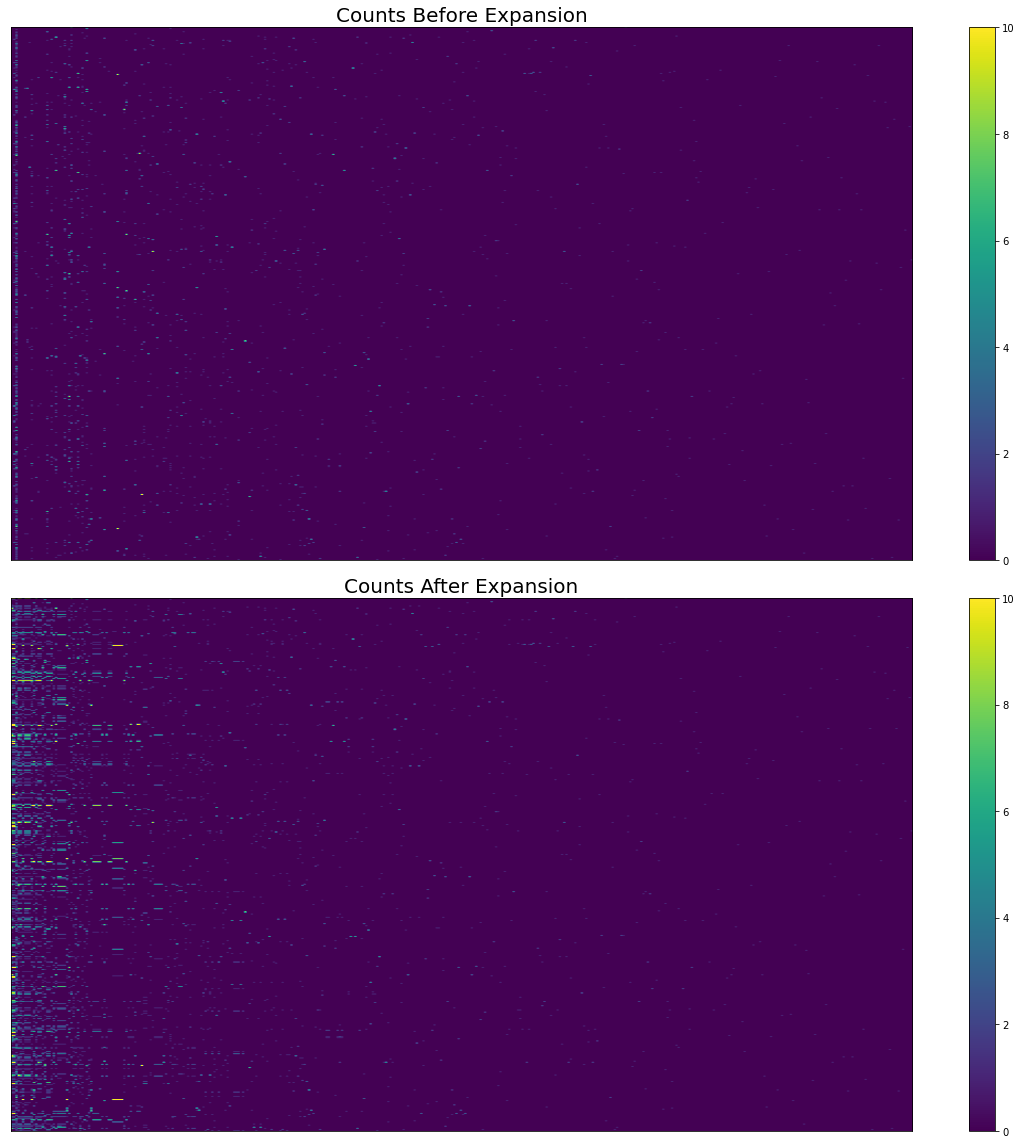

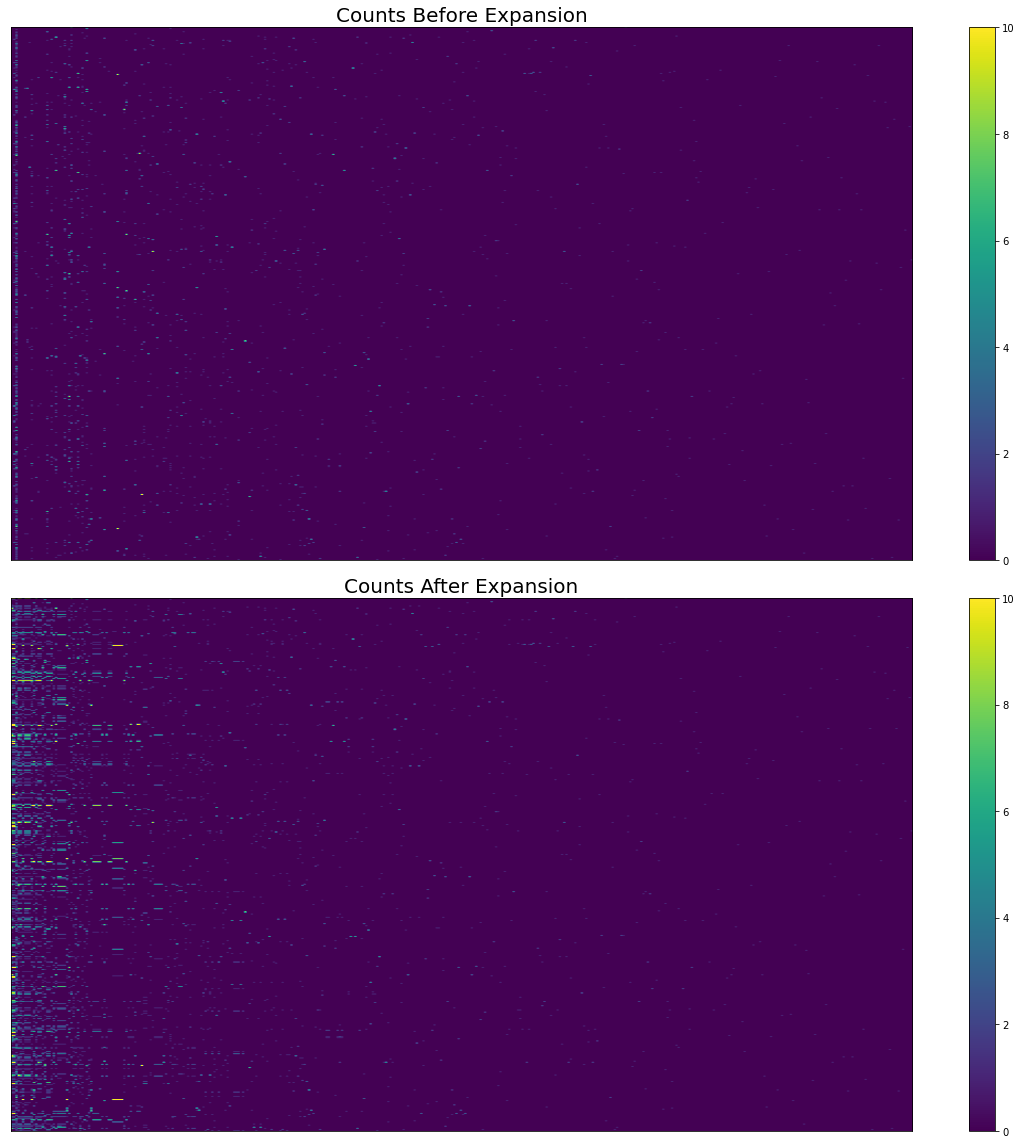

In [7]:
# Raw counts
fig, axes = plt.subplots(figsize=(16, 16), nrows=2, sharex=True)
pos = axes[0].imshow(
    cogat_counts_df[columns].values,
    aspect="auto",
    vmin=0,
    vmax=10,
)
fig.colorbar(pos, ax=axes[0])
axes[0].set_title("Counts Before Expansion", fontsize=20)
axes[0].yaxis.set_visible(False)
axes[0].xaxis.set_visible(False)
axes[0].set_ylabel("Study", fontsize=16)
axes[0].set_xlabel("Cognitive Atlas Term", fontsize=16)

# Expanded counts
pos = axes[1].imshow(
    expanded_df[columns].values,
    aspect="auto",
    vmin=0,
    vmax=10,
)
fig.colorbar(pos, ax=axes[1])
axes[1].set_title("Counts After Expansion", fontsize=20)
axes[1].yaxis.set_visible(False)
axes[1].xaxis.set_visible(False)
axes[1].set_ylabel("Study", fontsize=16)
axes[1].set_xlabel("Cognitive Atlas Term", fontsize=16)

fig.tight_layout()
glue("figure_cogat_expansion", fig, display=False)

```{glue:figure} figure_cogat_expansion
:name: "figure_cogat_expansion"
:align: center

The effect of hierarchical expansion on Cognitive Atlas term counts from abstracts in Neurosynth's first 500 papers. There are too many terms and studies to show individual labels.
```

In [8]:
# Here we delete the recent variables for the sake of reducing memory usage
del cogatlas, id_df, rel_df, cogat_counts_df, rep_text_df
del weights, expanded_df, series, columns

## Latent Dirichlet allocation

**Latent Dirichlet allocation** (LDA) {cite:p}`Blei2003-lh` was originally combined with meta-analytic neuroimaging data in {cite:t}`Poldrack2012-it`.
LDA is a generative topic model which, for a text corpus, builds probability distributions across documents and words.
In LDA, each document is considered a mixture of topics.
This works under the assumption that each document was constructed by first randomly selecting a topic based on the document's probability distribution across topics, and then randomly selecting a word from that topic based on the topic's probability distribution across words.
While this is not a useful generative model for producing documents, LDA is able to discern cohesive topics of related words.
{cite:t}`Poldrack2012-it` were able to apply LDA to full texts from neuroimaging articles in order to develop cognitive neuroscience-related topics and to run topic-wise meta-analyses.
This method produces two sets of probability distributions: (1) the probability of a word given topic and (2) the probability of a topic given article.

NiMARE uses a Python-based interface to the MALLET Java library {cite:p}`mccallum2002mallet` to implement LDA.
NiMARE will download MALLET automatically, when necessary.

Here, we train an LDA model ({py:class}`nimare.annotate.lda.LDAModel`) on the first 500 studies of the Neurosynth `Dataset`, with 100 topics in the model.

In [9]:
from nimare import annotate

lda_model = annotate.lda.LDAModel(
    neurosynth_dset_first_500.texts,
    text_column="abstract",
    n_topics=100,
    n_iters=10000,
)
lda_model.fit()

INFO:nimare.extract.utils:Dataset created in /home/data/nbc/misc-projects/Salo_NiMARE/nimare-paper/data/mallet__temp


INFO:nimare.extract.utils:Dataset created in /home/data/nbc/misc-projects/Salo_NiMARE/nimare-paper/data/mallet_model


INFO:nimare.annotate.lda:Texts folder not found. Creating text files...


INFO:nimare.annotate.lda:Generating topics...


Labels = 
   /home/data/nbc/misc-projects/Salo_NiMARE/nimare-paper/data/mallet_model/texts


Data loaded.


Coded LDA: 100 topics, 7 topic bits, 1111111 topic mask
max tokens: 244
total tokens: 59901


<10> LL/token: -8.79953
<20> LL/token: -8.54733


<30> LL/token: -8.43529
<40> LL/token: -8.34888



0	0.005	processing imaging encoding magnetic differences network frontal resonance middle msec anatomy event involved higher regions scalp recognition characterized component 
1	0.005	regions processes activity results resonance executive imaging gyrus cortex lexical human differentially support including interactions integration suggesting connectivity component 
2	0.005	control magnetic tapping observed involved resonance location revealed action presented cue supplementary activations region specifically internal requires examine sensations 
3	0.005	activation primary contrast stroop fmri data sequential level differential visceral response neural organization found spectral frequency type analyses demonstrate 
4	0.005	functional visual resonance compared found vestibular neurons presented input presentation primary contralateral performed sulcus instructed lobe easy thalamus functions 
5	0.005	verbal activations modality line hallucinations neural test magnetic imaging processing 

<70> LL/token: -8.20383
<80> LL/token: -8.16734
<90> LL/token: -8.14142



0	0.005	encoding processing resonance regions network frontal magnetic imaging differences msec involved anatomy sensitivity anatomical studies recognition event salient recent 
1	0.005	regions activity imaging processes resonance cortex results lexical findings support differentially anterior interactions tone integration human based suggesting connectivity 
2	0.005	control tapping involved movements magnetic observed specifically order cue action supplementary presented judgment set examine employed requires types internal 
3	0.005	activation primary stroop data sequential tones fmri neural visceral differential accd imagined mechanisms evoke cingulate comparisons groups contrast polyrhythmic 
4	0.005	functional sulcus contralateral eye compared vestibular neurons input functions single thalamus found central presented physiological easy upper presentation instructed 
5	0.005	verbal neural activations line imaging external investigated investigate test magnetic rehearsal consistent 

<120> LL/token: -8.07044
<130> LL/token: -8.05349
<140> LL/token: -8.03283



0	0.005	processing encoding imaging resonance magnetic functional frontal network regions sensitivity differences middle msec anatomical recent investigated studies anatomy abnormalities 
1	0.005	regions processes activity imaging resonance support findings study anterior lexical results cortex performed differentially component based suggesting finding executive 
2	0.005	control imaging involved tapping magnetic activity suggest movements specifically observed judgment types order action presented activations set examine internal 
3	0.005	activation primary stroop data sequential differential rate visceral cingulate stimuli accd contrast direct cortical groups polyrhythmic spectral muscle fingers 
4	0.005	functional sulcus resonance single vestibular neurons input central visual contralateral function functions presented insular perception thalamus physiological easy hemispheres 
5	0.005	verbal neural healthy activations line test imaging processing lobe left rehearsal magnetic acc c

<170> LL/token: -7.99604
<180> LL/token: -7.98378
<190> LL/token: -7.97295



0	0.005	processing frontal resonance encoding magnetic regions middle functional network sensitivity differences msec involved imaging abnormalities meg presentation event anatomy 
1	0.005	regions activity processes study imaging processing resonance support findings lexical results cortex differentially executive integration suggesting anterior finding connectivity 
2	0.005	control imaging magnetic involved tapping types employed specifically observed suggest activations performed order lobule movements set action activity internal 
3	0.005	activation stroop ganglia basal fmri stimuli rate sequential primary visceral accd differential cingulate data contrast fingers polyrhythmic muscle analyses 
4	0.005	functional visual sulcus cutaneous input vestibular neurons resonance central single functions contralateral perception function thalamus instructed showed easy physiological 
5	0.005	verbal neural imaging line test healthy representation magnetic volunteers length activations acc lob

<230> LL/token: -7.94105
<240> LL/token: -7.9334

0	0.005	processing resonance encoding imaging magnetic regions differences middle frontal network gyri msec sensitivity functional anatomy meg presentation component involved 
1	0.005	activity regions processes imaging processing study support lexical finding anterior resonance results cortex integration show suggesting aspects findings interactions 
2	0.005	control tapping imaging magnetic involved specifically types employed movements observed performed set order external cue action internal revealed varied 
3	0.005	activation basal stroop ganglia fmri cingulate stimuli data differential visceral sequential primary accd contrast polyrhythmic muscle taps temporally mechanisms 
4	0.005	functional sulcus function resonance contralateral cutaneous magnetic vestibular neurons input single functions showed instructed compared thalamus contrast ipsilateral visual 
5	0.005	verbal neural imaging line temporal volunteers length healthy test mag

<260> LL/token: -7.93051
<270> LL/token: -7.91355
<280> LL/token: -7.90924


<290> LL/token: -7.90029

0	0.005	processing magnetic imaging resonance network gyri differences frontal encoding msec anatomical studies functional abnormalities including presentation sensitivity meg pattern 
1	0.005	activity regions processing processes cortex imaging study results support findings anterior finding connectivity lexical integration suggesting resonance show tone 
2	0.005	control involved imaging tapping magnetic order fmri types set action employed varied lobule internal premotor performed external controlling specifically 
3	0.005	stroop basal activation ganglia sequential visceral data accd interference polyrhythmic muscle noise differential cingulate rate level mechanisms simon stp 
4	0.005	functional function sulcus contralateral cutaneous input magnetic vestibular single neurons visual orientation functions resonance perception thalamus contrast ipsilateral central 
5	0.005	verbal functional imaging neural magnetic line compared volunteers test healthy length ac

<320> LL/token: -7.88373
<330> LL/token: -7.87571
<340> LL/token: -7.87753



0	0.005	processing functional imaging gyri resonance magnetic network encoding frontal studies anatomical differences found presentation sensitivity abnormalities meg middle characterized 
1	0.005	regions activity processing processes support imaging resonance lexical connectivity anterior study results cortex findings suggesting finding integration represent interactions 
2	0.005	control tapping magnetic imaging order fmri types set specifically involved employed action performed varied internal lobule external judgment controlling 
3	0.005	stroop ganglia basal sequential interference stimuli visceral accd differential data polyrhythmic muscle mechanisms rate noise simon stp finally times 
4	0.005	resonance functional sulcus cutaneous vestibular function visual magnetic input perception central single neurons functions orientation contrast significance instructed physiological 
5	0.005	verbal imaging temporal compared line neural delay volunteers length healthy test functional magnet

<380> LL/token: -7.84982
<390> LL/token: -7.85063

0	0.005	processing frontal magnetic imaging functional resonance gyri encoding network investigated including anatomical differences anterior sensitivity meg presentation abnormalities structures 
1	0.005	regions activity processing imaging processes cortex support anterior connectivity network lexical study findings results component present finding integration suggesting 
2	0.005	control tapping imaging magnetic involved order resonance revealed types set employed internal performed action external lobule present location constant 
3	0.005	stroop ganglia basal stimuli sequential interference differential data visceral accd cutaneous mechanisms polyrhythmic muscle noise cingulate simon stp question 
4	0.005	functional function visual sulcus vestibular perception resonance input central orientation thalamus magnetic neurons single show adjacent cutaneous functions physiological 
5	0.005	verbal imaging functional neural magnetic compare

<410> LL/token: -7.83938
<420> LL/token: -7.84066
<430> LL/token: -7.84034


<440> LL/token: -7.8328

0	0.005	processing functional encoding frontal imaging gyri found resonance studies anatomical network sensitivity including presentation investigated magnetic meg abnormalities fmri 
1	0.005	regions cortex activity functional imaging processing processes results support anterior network connectivity resonance lexical findings study operations based finding 
2	0.005	control tapping imaging order observed magnetic employed set specifically internal action lobule movements involved performed types higher external comparison 
3	0.005	basal stroop ganglia sequential stimuli cutaneous visceral interference differential accd experimental data polyrhythmic muscle direct mechanisms comparisons simon stp 
4	0.005	functional visual sulcus function vestibular orientation resonance magnetic central input perception neurons functions show single humans important stereopsis parts 
5	0.005	verbal imaging compared magnetic temporal delay line volunteers components test functio

<470> LL/token: -7.81824
<480> LL/token: -7.82022
<490> LL/token: -7.81913



0	0.005	processing network imaging functional frontal magnetic resonance gyri revealed anterior studies anatomical encoding sensitivity including meg abnormalities middle investigated 
1	0.005	regions functional cortex processes processing imaging activity connectivity network support anterior findings results resonance distributed lexical show suggesting finding 
2	0.005	control tapping imaging movements involved order resonance magnetic observed action set types employed internal external performed specifically ventrolateral lobule 
3	0.005	stroop basal ganglia interference cutaneous differential stimuli data visceral accd mechanisms muscle noise direct comparisons anterior stp experimental programming 
4	0.005	functional visual sulcus resonance function vestibular single neurons orientation central perception magnetic functions humans input show varying stereopsis upper 
5	0.005	verbal compared line delay volunteers imaging temporal asked magnetic functional components test length 

<530> LL/token: -7.80977
<540> LL/token: -7.80337

0	0.005	processing imaging resonance network magnetic encoding data functional investigated gyri including anatomical differences revealed studies sensitivity meg recent presentation 
1	0.005	regions functional cortex processing activity processes imaging human anterior connectivity network results support resonance magnetic findings distributed evidence lexical 
2	0.005	control tapping movements imaging performed magnetic set order internal observed resonance employed action lobule involved types external comparison syllables 
3	0.005	stroop basal ganglia interference data cutaneous functional visceral differential accd mechanisms stimuli experimental direct combination stp temporally color question 
4	0.005	functional magnetic sulcus function vestibular orientation input visual resonance single neurons perception show central functions stereopsis maximum instructed upper 
5	0.005	verbal fmri functional compared imaging delay temporal

<560> LL/token: -7.79964
<570> LL/token: -7.79456
<580> LL/token: -7.79816


<590> LL/token: -7.7896

0	0.005	processing functional magnetic imaging resonance network data including revealed sensitivity suggest anatomical encoding studies investigated recent meg gyri widespread 
1	0.005	regions functional cortex imaging activity processes resonance support human magnetic processing connectivity anterior findings network finding component results distributed 
2	0.005	control tapping movements imaging resonance order involved magnetic performed internal observed action employed set types external comparison controlling specifically 
3	0.005	stroop ganglia basal interference data cutaneous activated differential visceral accd mechanisms stimuli combination direct word times stp temporally distinguish 
4	0.005	sulcus visual function functional single vestibular resonance input magnetic neurons orientation perception central perform functions stereopsis upper natural varying 
5	0.005	verbal fmri imaging functional magnetic compared resonance temporal line length tes

<620> LL/token: -7.78287
<630> LL/token: -7.78551
<640> LL/token: -7.78008



0	0.005	processing imaging resonance magnetic functional network data revealed studies encoding frontal stimuli investigated including gyri recent presentation sensitivity widespread 
1	0.005	functional regions cortex imaging activity processes resonance magnetic connectivity human processing network findings support integration cortical anterior results finding 
2	0.005	control movements resonance tapping imaging involved magnetic performed observed order action employed demonstrated comparison types set internal specifically external 
3	0.005	stroop basal ganglia interference data cutaneous visceral time accd differential activated experimental combination mechanisms stimuli temporally noise direct analysis 
4	0.005	function sulcus visual human functional input magnetic vestibular orientation neurons single central resonance neuronal instructed stereopsis perform functions important 
5	0.005	verbal fmri temporal imaging functional compared line healthy test span asked magnetic compo

<680> LL/token: -7.76873
<690> LL/token: -7.76529

0	0.005	processing imaging magnetic resonance network functional data studies encoding revealed suggest stimuli investigated including gyri presentation paradigm structures meg 
1	0.005	regions functional cortex activity imaging processes magnetic connectivity support resonance processing anterior found network findings cortical results integration finding 
2	0.005	control tapping movements imaging resonance performed observed magnetic order employed action internal external involved specifically ventrolateral set demonstrated basic 
3	0.005	ganglia basal stroop time interference data cutaneous activated differential visceral accd combination mechanisms adhd identify direct counting paradigm temporally 
4	0.005	function visual functional sulcus human vestibular orientation input neurons perception central single humans swallowing upper instructed functions area stereopsis 
5	0.005	verbal functional fmri temporal compared test magnetic 

<710> LL/token: -7.75571
<720> LL/token: -7.75926
<730> LL/token: -7.75401


<740> LL/token: -7.75252

0	0.005	processing magnetic imaging functional resonance network encoding studies frontal data including revealed presentation paradigm stimuli suggest middle gyri anatomical 
1	0.005	functional regions imaging cortex activity processes resonance cortical magnetic network processing connectivity results anterior integration support findings based distributed 
2	0.005	tapping movements magnetic control resonance involved observed imaging action order employed internal performed external set degree controlling specifically ratio 
3	0.005	ganglia basal stroop interference activated time differential cutaneous visceral accd paradigm adhd combination direct counting identify data temporally phenomenon 
4	0.005	human function sulcus visual orientation single vestibular input humans magnetic swallowing neurons perception functional perform central upper maximum important 
5	0.005	verbal imaging functional temporal test line fmri compared length asked magnetic showed 

<770> LL/token: -7.75954
<780> LL/token: -7.75702
<790> LL/token: -7.74914



0	0.005	processing resonance imaging functional magnetic network encoding stimuli cortex studies data investigated revealed gyri paradigm presentation lateral structures middle 
1	0.005	functional cortex regions imaging processing cortical activity magnetic resonance network connectivity processes support findings found evidence human show based 
2	0.005	resonance control tapping imaging movements magnetic involved performed order employed bilateral internal external set action observed types demonstrated subject 
3	0.005	stroop ganglia basal data activated interference cutaneous differential visceral time accd paradigm mechanisms phenomenon counting adhd combination identify direct 
4	0.005	human functional sulcus function visual orientation single vestibular input magnetic swallowing neurons perception humans instructed depth stimulus parts considered 
5	0.005	verbal experiment fmri imaging functional line test compared asked activated components healthy list centre trace broca leng

<830> LL/token: -7.7433
<840> LL/token: -7.73886

0	0.005	functional resonance processing magnetic network imaging stimuli encoding paradigm suggest data revealed gyri middle anatomical presentation lateral investigated meg 
1	0.005	functional cortex regions imaging activity processes cortical magnetic processing connectivity results network resonance support integration human show anterior evidence 
2	0.005	control movements tapping imaging resonance magnetic involved action order employed observed performed pacing set subject internal external bilateral types 
3	0.005	basal ganglia stroop activated time interference data cutaneous visceral differential mechanisms accd adhd counting direct phenomenon combination paradigm network 
4	0.005	human functional sulcus function orientation single vestibular input neurons visual perception depth instructed central upper parts considered humans stereopsis 
5	0.005	verbal functional experiment activated fmri line healthy components asked test im

<860> LL/token: -7.74424
<870> LL/token: -7.7428
<880> LL/token: -7.74229


<890> LL/token: -7.73681

0	0.005	processing functional imaging magnetic resonance network encoding frontal studies data investigated revealed gyri meg distributed middle stimuli suggest widespread 
1	0.005	functional regions cortex imaging activity resonance processes cortical magnetic connectivity network study support integration processing suggesting represent evidence findings 
2	0.005	movements control magnetic resonance tapping involved imaging observed action performed types employed set order pacing internal external subject bilateral 
3	0.005	ganglia basal stroop activated interference cutaneous differential visceral accd mechanisms network adhd counting phenomenon combination paradigm direct distinguish distributed 
4	0.005	human function functional orientation single visual vestibular input sulcus neurons perception instructed depth upper show varying cerebral stereopsis perform 
5	0.005	verbal experiment functional line components fmri asked length test list centre activat

<920> LL/token: -7.72862
<930> LL/token: -7.73388
<940> LL/token: -7.73162



0	0.005	imaging processing magnetic resonance functional temporal network encoding frontal stimuli revealed data middle gyri studies anatomical paradigm investigated anterior 
1	0.005	functional regions cortex imaging activity resonance cortical network connectivity magnetic processing findings study evidence support previously integration results finding 
2	0.005	movements tapping control resonance magnetic imaging observed types action involved order pacing employed set revealed performed internal sequential bilateral 
3	0.005	basal stroop ganglia activated interference cutaneous differential time visceral accd network mechanisms adhd phenomenon paradigm counting combination visuomotor direct 
4	0.005	human function orientation single input sulcus visual vestibular humans functional neurons perception central depth upper cerebral show stereopsis trial 
5	0.005	verbal functional experiment fmri imaging line healthy length asked study list components centre activated test broca planar

<980> LL/token: -7.72534
<990> LL/token: -7.7263

0	0.005	imaging functional processing resonance magnetic network encoding stimuli gyri revealed studies lateral middle data temporal inferior distributed anatomical investigated 
1	0.005	functional imaging cortex regions activity resonance cortical magnetic study network support processing evidence human connectivity integration show processes finding 
2	0.005	movements control tapping resonance magnetic involved observed imaging order pacing employed bilateral sequential set internal types revealed external action 
3	0.005	basal ganglia stroop activated interference cutaneous differential mechanisms time visceral accd paradigm direct adhd counting cognitive action phenomenon identify 
4	0.005	human visual orientation function sulcus vestibular input single neurons cerebral humans parts perception depth trial show stereopsis central modified 
5	0.005	verbal experiment fmri line differential test asked activated healthy list centre compo

<1010> LL/token: -7.72865
<1020> LL/token: -7.72411
<1030> LL/token: -7.72297


<1040> LL/token: -7.72723

0	0.005	imaging functional processing resonance magnetic temporal network encoding anatomical stimuli revealed studies gyri underlying data paradigm middle anterior distributed 
1	0.005	functional regions cortex imaging resonance magnetic activity cortical processing processes network study results integration findings connectivity support show suggesting 
2	0.005	movements control tapping resonance imaging observed magnetic bilateral employed involved order pacing set revealed sequential performed types internal external 
3	0.005	interference stroop ganglia basal activated time cutaneous visceral differential cognitive accd adhd counting mechanisms combination direct distinct rest identify 
4	0.005	human orientation visual function vestibular input single sulcus neurons central depth perception upper humans stereopsis parts modified cip trial 
5	0.005	verbal fmri activated experiment line healthy asked components length test list differential centre broca ju

<1070> LL/token: -7.71677
<1080> LL/token: -7.71986
<1090> LL/token: -7.71688



0	0.005	imaging functional processing magnetic network resonance revealed encoding data investigated posterior distributed studies gyri paradigm underlying anterior widespread meg 
1	0.005	functional regions cortex activity imaging magnetic resonance cortical human processing network anterior evidence component support connectivity integration processes finding 
2	0.005	movements control tapping imaging resonance magnetic observed order involved pacing sequential bilateral internal types set revealed performed polyrhythmic taps 
3	0.005	interference basal ganglia stroop activated cutaneous visceral accd differential mechanisms cognitive distinct time adhd counting supporting combination direct action 
4	0.005	human visual orientation single sulcus vestibular input function humans perception neurons upper depth central stereopsis modified electrophysiological cip trial 
5	0.005	verbal fmri line experiment differential asked length activated healthy components list centre gyrus judge me

<1130> LL/token: -7.70885
<1140> LL/token: -7.71174

0	0.005	functional imaging processing fmri resonance network magnetic encoding studies revealed posterior data anatomical investigated gyri stimuli component middle research 
1	0.005	functional regions cortex imaging cortical magnetic resonance activity human network processes processing finding evidence suggest study integration support anterior 
2	0.005	movements control tapping imaging resonance observed magnetic involved pacing revealed order sequential set stronger employed internal bilateral types external 
3	0.005	interference basal ganglia stroop activated cutaneous cognitive visceral accd differential data resolution adhd direct counting mechanisms distinct experimental color 
4	0.005	human sulcus orientation function single vestibular input humans perception visual neurons depth upper parts cerebral stereopsis contribution show modified 
5	0.005	verbal line activated test experiment asked differential length fmri list compo

<1160> LL/token: -7.71072
<1170> LL/token: -7.70682
<1180> LL/token: -7.71101


<1190> LL/token: -7.70639

0	0.005	functional imaging magnetic resonance processing network data revealed encoding fmri posterior studies gyri anterior middle paradigm research anatomical component 
1	0.005	functional regions cortex imaging magnetic resonance activity anterior cortical human component processing network support study finding mode show connectivity 
2	0.005	movements control tapping resonance magnetic observed imaging action involved sequential pacing employed internal revealed bilateral order set stronger types 
3	0.005	interference basal ganglia stroop activated cognitive cutaneous resolution differential visceral accd adhd direct counting mechanisms multiple combination color identify 
4	0.005	human sulcus orientation visual humans function single vestibular input perception neurons upper depth central parts show stereopsis varying thalamus 
5	0.005	verbal fmri activated line list asked components differential healthy experiment comparison length test planar memorize

<1220> LL/token: -7.70897
<1230> LL/token: -7.70411
<1240> LL/token: -7.70512



0	0.005	magnetic imaging functional resonance fmri studies network processing encoding revealed brain data underlying middle gyri paradigm anatomical component pattern 
1	0.005	functional regions activity cortex magnetic imaging cortical human resonance found processing support anterior network evidence component findings suggest show 
2	0.005	movements tapping control imaging resonance magnetic observed set action involved pacing sequential bilateral left internal revealed order types polyrhythmic 
3	0.005	interference ganglia basal stroop activated cutaneous cognitive visceral accd differential mechanisms distinct multiple adhd counting higher color direct comparisons 
4	0.005	human orientation function vestibular input visual single perception neurons depth humans show sulcus stereopsis hand important modified parts proprioceptive 
5	0.005	verbal activated line asked list comparison components length fmri experiment found healthy differential planar memorized centre levodopa scenes

<1280> LL/token: -7.70248
<1290> LL/token: -7.69481

0	0.005	imaging resonance magnetic functional brain network processing fmri encoding revealed studies paradigm underlying data pattern including suggest gyri posterior 
1	0.005	functional regions cortex imaging activity cortical resonance magnetic network anterior connectivity evidence finding component distinct show interaction mode support 
2	0.005	movements tapping control magnetic imaging resonance observed action involved bilateral left internal pacing sequential set revealed executed polyrhythmic taps 
3	0.005	interference ganglia basal stroop activated cutaneous differential cognitive visceral anterior accd direct higher adhd counting supporting color combination identify 
4	0.005	human orientation function vestibular single input perception visual neurons depth humans upper contribution show stereopsis important lower modified induce 
5	0.005	line activated differential verbal found list components asked fmri comparison test 

<1310> LL/token: -7.70413
<1320> LL/token: -7.69345
<1330> LL/token: -7.69518


<1340> LL/token: -7.69381

0	0.005	imaging functional magnetic resonance processing brain network posterior data fmri studies encoding suggest gyri middle investigated revealed underlying neuronal 
1	0.005	functional regions activity cortical imaging cortex resonance human network found magnetic anterior brain component findings connectivity evidence integration finding 
2	0.005	movements tapping magnetic control imaging resonance observed action pacing sequential internal revealed left set involved bilateral initiation order external 
3	0.005	interference basal ganglia stroop activated cutaneous differential visceral cognitive accd higher employed counting adhd supporting experimental combination paradigm color 
4	0.005	human orientation single function vestibular input visual perception neurons humans hand depth contribution show stereopsis upper developed central modified 
5	0.005	line activated list verbal differential asked components comparison centre differentially test planar l

<1370> LL/token: -7.69282
<1380> LL/token: -7.68869
<1390> LL/token: -7.68529



0	0.005	functional magnetic imaging network resonance processing brain fmri areas encoding paradigm revealed underlying data studies component posterior neuronal middle 
1	0.005	functional regions imaging resonance cortex cortical magnetic found anterior integration network evidence connectivity component support distinct finding human directly 
2	0.005	movements tapping control imaging magnetic resonance set observed sequential action pacing involved internal initiation order revealed external polyrhythmic taps 
3	0.005	interference basal ganglia stroop activated differential cutaneous visceral accd identify cognitive adhd counting higher employed experimental combination color recruitment 
4	0.005	human orientation input vestibular function single visual perception neurons show depth upper hand stereopsis central humans modified proprioceptive varying 
5	0.005	line activated verbal asked list components differential found differentially comparison centre length test judge levodopa s

<1430> LL/token: -7.68932
<1440> LL/token: -7.6885

0	0.005	imaging resonance magnetic fmri processing areas brain functional network data encoding revealed posterior studies investigated gyri paradigm underlying middle 
1	0.005	functional regions imaging magnetic resonance cortical activity cortex suggest connectivity human component integration anterior network support distinct finding previously 
2	0.005	movements control tapping resonance magnetic imaging set action involved pacing observed initiation sequential left order internal stronger types polyrhythmic 
3	0.005	interference activated basal ganglia stroop differential cutaneous cognitive visceral accd employed identify adhd direct counting supporting combination color higher 
4	0.005	human orientation vestibular input function single neurons depth visual upper perception central humans show stereopsis contribution modified proprioceptive varying 
5	0.005	line activated verbal list differentially differential centre asked comp

<1460> LL/token: -7.6935
<1470> LL/token: -7.68973
<1480> LL/token: -7.69293


<1490> LL/token: -7.68406

0	0.005	areas imaging processing fmri resonance functional magnetic network brain data encoding revealed underlying suggest gyri component investigated including paradigm 
1	0.005	functional regions imaging cortical magnetic resonance brain cortex human support findings medial evidence distinct anterior connectivity integration finding found 
2	0.005	movements imaging control tapping resonance magnetic set observed left action involved pacing initiation external sequential performance internal order basis 
3	0.005	interference ganglia basal stroop activated activation cutaneous higher experiment visceral accd direct differential cognitive supporting adhd employed combination color 
4	0.005	human function orientation vestibular input visual neurons depth single upper perception humans parieto hand show modified parts contribution varying 
5	0.005	line activated verbal list differential comparison centre differentially pre planar determine length test levodopa 

<1520> LL/token: -7.68434
<1530> LL/token: -7.68159
<1540> LL/token: -7.68692



0	0.005	functional processing imaging areas magnetic resonance network brain encoding data fmri anterior revealed posterior component underlying studies gyri paradigm 
1	0.005	regions functional imaging brain cortical resonance magnetic processing connectivity network cortex human support distinct evidence found medial anatomically activity 
2	0.005	movements control tapping resonance left imaging magnetic set involved observed pacing order initiation sequential external basis action investigate internal 
3	0.005	interference ganglia basal stroop activation activated cutaneous differential visceral accd supporting identify direct cognitive adhd combination counting somatosensory color 
4	0.005	human orientation function visual input vestibular single neurons show humans hand component adjacent contribution parieto modified parts proprioceptive varying 
5	0.005	line list verbal activated comparison differentially asked pre underwent length centre comparisons test levodopa ti planar sce

<1580> LL/token: -7.68546
<1590> LL/token: -7.6767

0	0.005	functional imaging areas magnetic processing resonance fmri network data brain encoding posterior suggest revealed anterior gyri paradigm distributed underlying 
1	0.005	functional regions imaging magnetic brain resonance activity cortex cortical support connectivity medial network human found integration anterior maps default 
2	0.005	movements tapping control resonance left imaging magnetic set involved observed pacing action initiation sequential internal external executed hemisphere stronger 
3	0.005	interference ganglia basal stroop activated cutaneous visceral differential activation accd employed higher paradigm direct adhd counting supporting activate identify 
4	0.005	human function orientation single visual vestibular input neurons humans show upper parts parieto adjacent modified cutaneous proprioceptive contribution hand 
5	0.005	activated line list verbal asked comparison test planar scenes judge echo performing d

<1610> LL/token: -7.68122
<1620> LL/token: -7.69079
<1630> LL/token: -7.67572


<1640> LL/token: -7.68039

0	0.005	functional areas magnetic imaging resonance processing network fmri encoding data revealed posterior suggest brain anterior middle gyri structures investigated 
1	0.005	functional regions imaging cortex resonance cortical magnetic brain connectivity support human activity medial network distinct integration found fronto suggest 
2	0.005	movements control tapping imaging magnetic resonance observed left set pacing initiation sequential action internal revealed basis hemisphere stronger polyrhythmic 
3	0.005	interference ganglia basal stroop activated activation cutaneous visceral higher accd direct adhd employed paradigm identify counting supporting differential subserving 
4	0.005	human orientation input vestibular visual function single humans show upper neurons parts parieto modified natural proprioceptive central component version 
5	0.005	line verbal activated list length differential differentially asked performing test scenes judge comparison ce

<1670> LL/token: -7.67631
<1680> LL/token: -7.67689
<1690> LL/token: -7.67495



0	0.005	areas magnetic functional resonance imaging network neuronal processing encoding brain suggest data fmri studies underlying posterior responses revealed component 
1	0.005	functional regions imaging activity cortex resonance magnetic human cortical brain support medial distinct connectivity network integration previously findings represent 
2	0.005	movements control tapping imaging resonance set order left magnetic pacing action initiation sequential internal observed revealed external polyrhythmic taps 
3	0.005	interference stroop ganglia basal activation activated cutaneous paradigm visceral accd higher adhd identify counting differential employed color direct supporting 
4	0.005	human orientation function single input visual vestibular humans upper parts neurons show modified developed proprioceptive hand central electrophysiological cutaneous 
5	0.005	line verbal activated list differential comparison differentially asked test planar judge performing length centre comparis

<1730> LL/token: -7.68271
<1740> LL/token: -7.68199

0	0.005	areas imaging functional magnetic processing resonance network brain data encoding suggest studies neuronal revealed component posterior underlying structures middle 
1	0.005	regions functional cortex imaging brain magnetic activity resonance cortical human medial connectivity support findings processing distinct network component integration 
2	0.005	movements control tapping resonance imaging left pacing magnetic initiation sequential set internal revealed performed external order polyrhythmic taps mode 
3	0.005	interference ganglia basal stroop activated cutaneous activation visceral accd adhd paradigm counting color differential supporting higher subserving behaviour identify 
4	0.005	human orientation input function vestibular single visual hand humans upper parts neurons adjacent modified proprioceptive evoked varying important somatosensory 
5	0.005	line activated verbal list differentially comparison test performing j

<1760> LL/token: -7.67468
<1770> LL/token: -7.67527
<1780> LL/token: -7.66884


<1790> LL/token: -7.6653

0	0.005	resonance functional imaging areas magnetic data encoding processing network brain posterior fmri suggest underlying component neuronal distributed middle gyri 
1	0.005	regions functional imaging activity brain resonance magnetic cortical cortex processing human medial anterior connectivity suggest distinct show findings dependent 
2	0.005	movements control tapping magnetic imaging resonance set pacing left initiation sequential internal revealed order external polyrhythmic taps mode antiphase 
3	0.005	interference ganglia basal activated stroop activation cutaneous visceral accd paradigm identify adhd counting differential higher color supporting behaviour direct 
4	0.005	human orientation function vestibular input single humans neurons visual important upper sensitive show modified parts proprioceptive central developed intentional 
5	0.005	line activated list verbal asked comparisons performing comparison test planar judge length centre levodopa sce

<1820> LL/token: -7.66906
<1830> LL/token: -7.66735
<1840> LL/token: -7.67084



0	0.005	imaging areas magnetic network resonance functional brain posterior studies encoding neuronal suggest data component revealed underlying responses processing middle 
1	0.005	regions functional brain imaging magnetic activity cortex cortical resonance medial human connectivity findings anterior support distinct dependent show represent 
2	0.005	movements control tapping resonance imaging left magnetic initiation pacing sequential set internal order external revealed polyrhythmic taps mode antiphase 
3	0.005	interference ganglia basal stroop activation cutaneous visceral activated accd paradigm higher adhd counting behaviour color identify direct supporting differential 
4	0.005	human orientation input function vestibular visual single important humans parts upper eye hand sensitive modified proprioceptive central neurons intentional 
5	0.005	activated list line length differentially verbal asked judgment differential planar performing determine comparison centre test suggests l

<1880> LL/token: -7.67513
<1890> LL/token: -7.67306

0	0.005	areas functional imaging fmri resonance magnetic network brain processing encoding data neuronal suggest component middle gyri posterior revealed underlying 
1	0.005	regions cortex functional imaging brain magnetic cortical resonance activity support processing medial connectivity human dependent findings distinct suggest show 
2	0.005	movements control tapping imaging resonance left magnetic finger pacing stimuli initiation sequential order external internal polyrhythmic taps stronger revealed 
3	0.005	interference basal ganglia stroop activated activation cutaneous visceral accd adhd supporting counting color paradigm identify component locus systems nuclei 
4	0.005	human orientation input function vestibular single visual hand important humans neurons parts eye show modified proprioceptive induce developed intentional 
5	0.005	line list length activated asked comparison performing differential comparisons verbal planar sce

<1910> LL/token: -7.66919
<1920> LL/token: -7.67235
<1930> LL/token: -7.66517


<1940> LL/token: -7.67035

0	0.005	functional imaging areas resonance magnetic processing fmri brain encoding anterior component data neuronal network posterior underlying suggest studies gyri 
1	0.005	regions functional magnetic imaging brain human cortical activity resonance processing cortex support medial distinct findings connectivity suggest dependent show 
2	0.005	movements tapping control magnetic left resonance pacing initiation set imaging internal order sequential polyrhythmic taps external mode tasks revealed 
3	0.005	interference ganglia basal stroop activation activated cutaneous visceral accd paradigm counting adhd color supporting identify differential word caudate rifg 
4	0.005	human orientation function vestibular visual input neurons single humans primary parts hand upper eye show modified proprioceptive central cognition 
5	0.005	line activated list asked differentially verbal comparison judgment differential length planar judge components centre scenes echo memoriz

<1970> LL/token: -7.66565
<1980> LL/token: -7.67031
<1990> LL/token: -7.66456



0	0.005	areas brain fmri functional resonance network imaging encoding posterior component data magnetic processing studies information neuronal revealed anterior underlying 
1	0.005	functional regions brain cortex imaging resonance cortical magnetic human processing activity support connectivity medial dependent distinct findings suggest anterior 
2	0.005	movements control tapping imaging resonance magnetic pacing initiation basis tasks brain sequential left investigate internal revealed set polyrhythmic taps 
3	0.005	interference basal ganglia stroop activation activated visceral cutaneous accd paradigm adhd counting color identify supporting word nuclei rifg subserving 
4	0.005	human orientation vestibular input function single humans neurons central visual hand parts upper cutaneous important show modified induce proprioceptive 
5	0.005	line verbal list asked activated differentially comparison judgements test judgment differential planar scenes judge performing length centre echo

<2030> LL/token: -7.67023
<2040> LL/token: -7.66985

0	0.005	functional imaging areas magnetic activation fmri resonance network brain encoding data component information studies processing anterior suggest posterior gyri 
1	0.005	functional regions brain imaging resonance cortex activity cortical magnetic support human processing medial anterior connectivity distinct specific suggest represent 
2	0.005	tapping control movements left imaging resonance magnetic pacing initiation sequential tasks internal order external basis set stronger revealed polyrhythmic 
3	0.005	interference stroop ganglia basal activated cutaneous visceral fmri accd counting adhd color word supporting identify network paradigm rifg subserving 
4	0.005	human orientation single vestibular input function neurons visual humans upper hand sensitive important show modified proprioceptive induce parts injury 
5	0.005	line activated list judgment volunteers performing differential comparison differentially test verbal pl

<2060> LL/token: -7.66824
<2070> LL/token: -7.66013
<2080> LL/token: -7.67178


<2090> LL/token: -7.66711

0	0.005	activation areas functional imaging brain resonance magnetic fmri processing encoding neuronal data component network posterior underlying middle evidence investigated 
1	0.005	regions functional imaging brain resonance magnetic cortical cortex activity processing medial support findings connectivity suggest directly maps subserve dependent 
2	0.005	control tapping movements imaging magnetic resonance pacing initiation sequential left internal revealed patterns sequence order polyrhythmic taps external mode 
3	0.005	interference basal stroop ganglia activated cutaneous visceral accd color activation adhd counting fmri supporting paradigm simon rifg subserving irrelevant 
4	0.005	human orientation function input vestibular single neurons hand humans visual parts sensitive upper important temporal modified proprioceptive internal developed 
5	0.005	line activated list verbal judgment comparison differentially asked test performing lines centre processin

<2120> LL/token: -7.66015
<2130> LL/token: -7.66255
<2140> LL/token: -7.66607



0	0.005	functional activation areas resonance brain imaging encoding network fmri magnetic posterior data neuronal processing component underlying anterior revealed middle 
1	0.005	functional regions brain imaging magnetic resonance cortex activity cortical human support findings processing medial suggest anterior connectivity represent directly 
2	0.005	tapping movements control imaging left pacing initiation internal revealed resonance order external polyrhythmic taps mode sequential antiphase modes figure 
3	0.005	interference stroop basal ganglia activated fmri activation cutaneous visceral accd activate color adhd counting neural paradigm supporting systems included 
4	0.005	human orientation function input vestibular visual single humans show parts neurons upper modified proprioceptive varying hand internal induce injury 
5	0.005	activated line judgment asked list differentially differential comparison lines centre volunteers planar length comparisons test judge echo performing 

<2180> LL/token: -7.66423
<2190> LL/token: -7.65997

0	0.005	activation functional resonance areas imaging magnetic brain fmri network processing posterior encoding data component studies neuronal middle revealed patterns 
1	0.005	functional regions brain imaging resonance magnetic cortical human activity support medial connectivity dependent findings cortex represent anterior lower consistently 
2	0.005	tapping control movements pacing left initiation imaging internal resonance sequential polyrhythmic taps external mode revealed order antiphase modes addition 
3	0.005	interference stroop ganglia basal activation activated cutaneous visceral accd paradigm adhd counting color systems supporting activate anterior simon employed 
4	0.005	human input orientation function vestibular single visual upper neurons hand humans parts developed show modified proprioceptive varying sensitive cognition 
5	0.005	activated activation line asked judgment list differential comparison centre differential

<2210> LL/token: -7.66567
<2220> LL/token: -7.66339
<2230> LL/token: -7.66375


<2240> LL/token: -7.66522

0	0.005	functional activation imaging areas brain magnetic resonance network encoding processing fmri data component anterior pattern anatomical studies neuronal posterior 
1	0.005	functional regions brain cortical imaging activity magnetic human resonance processing support cortex medial connectivity findings specific directly lower interaction 
2	0.005	movements tapping control imaging resonance left pacing initiation sequential order internal revealed polyrhythmic taps external addition mode strategy activities 
3	0.005	interference stroop ganglia basal activated cutaneous activation visceral accd adhd supporting paradigm activate counting correlated color simon irrelevant employed 
4	0.005	human orientation function input vestibular single neurons parts visual show ventral modified developed proprioceptive varying version upper induce injury 
5	0.005	activated activation line asked judgment length list comparison differential lines centre differentially c

<2270> LL/token: -7.66337
<2280> LL/token: -7.65944
<2290> LL/token: -7.66022



0	0.005	activation imaging areas functional resonance magnetic data network encoding brain processing prefrontal studies posterior component fmri anterior responses anatomical 
1	0.005	functional regions brain imaging cortex cortical resonance activity areas processing support human dependent magnetic connectivity findings suggests medial suggest 
2	0.005	tapping movements imaging control resonance pacing sequential initiation experiment order internal polyrhythmic taps external mode revealed antiphase addition figure 
3	0.005	interference stroop ganglia basal activated cutaneous visceral accd adhd counting activation supporting activate color systems included simon identify rifg 
4	0.005	human input orientation single function vestibular visual humans neurons important show cognition modified upper induce developed proprioceptive full version 
5	0.005	activated line asked list judgment length differential comparison lines centre comparisons judge basis planar echo horizontal middle t

<2330> LL/token: -7.66562
<2340> LL/token: -7.66515

0	0.005	activation areas functional imaging brain resonance network magnetic encoding posterior prefrontal fmri data processing component anterior anatomical neuronal revealed 
1	0.005	regions functional brain cortex imaging resonance cortical processing magnetic areas human activity dependent support connectivity suggests medial distinct anterior 
2	0.005	tapping movements pacing experiment control imaging initiation resonance internal sequential order polyrhythmic taps external mode statistical revealed figure trains 
3	0.005	interference basal ganglia stroop cutaneous activated visceral accd adhd counting supporting activate simon color differential rifg subserving distracted irrelevant 
4	0.005	human orientation function vestibular input neurons visual humans single show parts cognition upper important modified induce proprioceptive full developed 
5	0.005	activated line asked list comparison judgment length differentially lines 

<2360> LL/token: -7.66045
<2370> LL/token: -7.65649
<2380> LL/token: -7.65756


<2390> LL/token: -7.65643

0	0.005	activation areas imaging functional resonance magnetic fmri data prefrontal network brain studies processing posterior evidence encoding neuronal patterns component 
1	0.005	regions functional brain imaging magnetic activity cortex cortical human areas support processing dependent resonance medial suggest connectivity lower suggests 
2	0.005	tapping movements imaging resonance control pacing initiation internal revealed polyrhythmic taps external mode order sequential vc rhythmic modes set 
3	0.005	interference basal ganglia stroop cutaneous activated visceral accd supporting adhd activate counting paradigm differential simon color hypotheses rifg subserving 
4	0.005	human function orientation input vestibular visual single show neurons humans parts upper varying modified developed proprioceptive hand cognition important 
5	0.005	activated judgment line list differentially asked differential length lines centre comparison judgements comparisons sugges

<2420> LL/token: -7.65435
<2430> LL/token: -7.65386
<2440> LL/token: -7.65568



0	0.005	activation areas imaging functional resonance magnetic fmri data prefrontal network processing brain posterior encoding neuronal component patterns remains evidence 
1	0.005	regions functional brain cortex cortical activity imaging areas magnetic support human connectivity medial resonance processing dependent distinct suggest anterior 
2	0.005	tapping movements pacing internal control initiation sequential polyrhythmic taps external mode set order lpi vc addition strategy programming ac 
3	0.005	interference basal ganglia stroop activated cutaneous visceral accd supporting activate color adhd counting paradigm similar differential included simon nuclei 
4	0.005	human function orientation input vestibular single humans visual show parts electrophysiological upper central important modified proprioceptive cognition full neurons 
5	0.005	activated judgment line differential list length lines centre asked suggests judgements test normal judge differentially underwent basis compar

<2480> LL/token: -7.65495
<2490> LL/token: -7.64998

0	0.005	activation areas imaging functional data magnetic fmri resonance network brain processing anterior prefrontal posterior encoding studies patterns component responses 
1	0.005	regions functional brain activity cortex cortical imaging magnetic resonance areas support human processing connectivity medial maps distinct default findings 
2	0.005	tapping movements visual pacing internal sequential initiation set polyrhythmic taps external mode stimuli modes repetitive lobule order lpi vc 
3	0.005	interference basal ganglia stroop activated cutaneous visceral accd color adhd counting activate paradigm nuclei simon supporting similar included subserving 
4	0.005	human single function orientation vestibular neurons humans input parts varying visual show modified upper proprioceptive important full electrophysiological developed 
5	0.005	activated line lines list judgment differential ht comparisons asked normal basis judgements test j

<2510> LL/token: -7.65271
<2520> LL/token: -7.65379
<2530> LL/token: -7.6438


<2540> LL/token: -7.64495

0	0.005	activation areas imaging resonance magnetic functional network processing brain fmri encoding posterior data component anterior prefrontal middle patterns studies 
1	0.005	functional brain cortex regions activity areas cortical support imaging resonance connectivity findings human magnetic processing default dependent medial maps 
2	0.005	tapping movements visual pacing control stimuli sequential internal initiation set polyrhythmic taps external mode antiphase continuation lpi vc rhythmic 
3	0.005	interference basal ganglia stroop activated cutaneous visceral accd color adhd supporting counting attentional included activate paradigm simon nuclei differing 
4	0.005	human orientation vestibular input function visual neurons humans single parts important upper show modified proprioceptive central cognition internal full 
5	0.005	line activated judgment list differential lines asked ht judgements normal judge length horizontal centre differentially echo 

<2570> LL/token: -7.65549
<2580> LL/token: -7.64869
<2590> LL/token: -7.65098



0	0.005	activation areas imaging brain functional resonance magnetic fmri processing data posterior network anterior encoding component revealed prefrontal underlying middle 
1	0.005	regions brain cortex functional cortical imaging areas resonance processing connectivity medial human support activity dependent findings magnetic lower interaction 
2	0.005	tapping movements pacing internal sequential visual external set order polyrhythmic taps mode control antiphase continuation trains lpi vc rhythmic 
3	0.005	interference basal ganglia stroop motor activated cutaneous visceral accd adhd counting included supporting color paradigm simon activate nuclei subserving 
4	0.005	human orientation input vestibular function neurons single visual parts important humans upper hand show modified proprioceptive central electrophysiological recent 
5	0.005	activated line judgment differentially list differential lines asked ht horizontal judgements judge basis centre test echo underwent length compar

<2630> LL/token: -7.64588
<2640> LL/token: -7.64692

0	0.005	activation areas fmri functional imaging magnetic posterior resonance network data prefrontal component anterior processing encoding pattern middle responses studies 
1	0.005	functional regions brain activity cortex imaging cortical support resonance magnetic processing connectivity human dependent show medial default maps subserve 
2	0.005	tapping movements visual pacing sequential internal control set polyrhythmic taps mode antiphase initiation continuation external trains lpi vc modes 
3	0.005	interference basal ganglia stroop activated cutaneous visceral accd color adhd paradigm counting supporting activate motor somatosensory simon hypotheses nuclei 
4	0.005	human function orientation vestibular input single neurons visual show upper parts important eye modified proprioceptive electrophysiological developed cutaneous injury 
5	0.005	line activated judgment lines list differential asked ht centre neural horizontal judgeme

<2660> LL/token: -7.65164
<2670> LL/token: -7.65114
<2680> LL/token: -7.64829


<2690> LL/token: -7.64532

0	0.005	activation functional areas resonance imaging magnetic fmri network processing data brain posterior component revealed encoding studies anatomical prefrontal gyri 
1	0.005	functional regions cortex brain imaging activity resonance magnetic cortical connectivity support medial processing human suggest interaction lower dependent cortices 
2	0.005	tapping visual finger movements pacing sequential internal polyrhythmic taps external mode set antiphase modes continuation lpi vc rhythmic initiation 
3	0.005	interference ganglia basal stroop activated cutaneous visceral accd color adhd paradigm counting activate simon nuclei included subserving differing intermittent 
4	0.005	human orientation function single vestibular input neurons important visual parts upper cognition modified developed proprioceptive show electrophysiological mnemonic injury 
5	0.005	activated line judgment list lines asked ht differential judgements centre horizontal differentially ju

<2720> LL/token: -7.64993
<2730> LL/token: -7.64712
<2740> LL/token: -7.65386



0	0.005	activation imaging functional areas resonance network processing fmri magnetic component data encoding brain middle revealed posterior pattern complex responses 
1	0.005	regions functional brain cortex imaging activity cortical resonance magnetic medial processing support connectivity human suggest show interaction findings lower 
2	0.005	tapping movements visual finger pacing sequential internal polyrhythmic taps external mode antiphase continuation trains lpi vc rhythmic modes initiation 
3	0.005	interference basal ganglia stroop cutaneous activated visceral accd color adhd counting activate supporting paradigm simon scores nuclei contrast intermittent 
4	0.005	human orientation vestibular input function neurons single visual parts show upper modified cip mediating proprioceptive central mnemonic injury ocular 
5	0.005	activated line judgment asked lines list ht differential centre horizontal judgements differentially judge basis length normal test suggests planar 
6	0.005	t

<2780> LL/token: -7.64336
<2790> LL/token: -7.64601

0	0.005	activation functional areas imaging resonance magnetic processing network fmri data brain encoding middle posterior component anterior revealed studies pattern 
1	0.005	functional regions brain cortex activity imaging medial resonance human cortical processing connectivity suggest support interaction modulated default findings lower 
2	0.005	tapping movements finger pacing sequential visual internal polyrhythmic taps continuation external mode set antiphase sequence lpi vc rhythmic modes 
3	0.005	interference basal ganglia stroop activated cutaneous visceral accd motor adhd counting supporting color paradigm simon scores infrequent design cerebellum 
4	0.005	human orientation function vestibular input neurons visual single parts show mediating central humans modified upper cip developed proprioceptive important 
5	0.005	line judgment activated asked lines list differential ht centre basis horizontal judgements differentially 

<2810> LL/token: -7.64005
<2820> LL/token: -7.64206
<2830> LL/token: -7.63823


<2840> LL/token: -7.64227

0	0.005	activation imaging functional areas resonance magnetic network brain fmri data component posterior encoding middle investigated anterior anatomical revealed pattern 
1	0.005	regions brain activity functional cortex imaging cortical resonance magnetic processing support connectivity medial human default directly suggest modulated findings 
2	0.005	tapping movements visual pacing sequential finger internal polyrhythmic taps external mode set antiphase sequence trains lpi vc rhythmic modes 
3	0.005	interference basal ganglia stroop activated cutaneous visceral accd color system adhd supporting activate counting hypotheses reduced scores subserving contrast 
4	0.005	human orientation function vestibular input neurons visual single eye upper developed central humans show modified induce parts cip cutaneous 
5	0.005	activated judgment line lines list asked ht judgements centre horizontal differentially comparisons judge length test suggests echo underwent b

<2870> LL/token: -7.64016
<2880> LL/token: -7.63612
<2890> LL/token: -7.63523



0	0.005	areas activation resonance functional imaging fmri magnetic network data revealed prefrontal encoding posterior brain component middle studies responses underlying 
1	0.005	regions functional brain cortex cortical support activity imaging magnetic processing human resonance connectivity findings suggest interaction default modulated lower 
2	0.005	tapping movements finger visual pacing sequential internal polyrhythmic taps external mode antiphase continuation set trains lpi vc modes initiation 
3	0.005	interference basal ganglia stroop activated cutaneous visceral accd adhd activate color counting included scores supported hypotheses nuclei violations subserving 
4	0.005	human orientation vestibular input function visual neurons single humans show upper parts modified cip mnemonic proprioceptive central important intensity 
5	0.005	line activated judgment length asked lines differentially ht list judgements horizontal suggests judge basis differential centre underwent comparis

<2930> LL/token: -7.63345
<2940> LL/token: -7.63546

0	0.005	activation areas brain functional resonance imaging network magnetic fmri encoding posterior data revealed component middle complex anterior anatomical underlying 
1	0.005	functional regions cortex brain imaging processing activity cortical resonance magnetic medial support connectivity human dependent suggest interaction represent directly 
2	0.005	tapping movements finger visual pacing sequential internal polyrhythmic taps external mode set sequence antiphase initiation repetitive lpi vc modes 
3	0.005	interference basal ganglia activated stroop cutaneous visceral accd color adhd counting paradigm supporting activate sensory contrast scores supported confirm 
4	0.005	human orientation vestibular function input visual humans single superior neurons parts eye central modified upper cip developed proprioceptive full 
5	0.005	line activated judgment differential length ht list lines judgements differentially asked suggests judg

<2960> LL/token: -7.64013
<2970> LL/token: -7.63738
<2980> LL/token: -7.63672


<2990> LL/token: -7.63501

0	0.005	activation areas imaging resonance functional magnetic network fmri brain encoding data revealed posterior component middle studies complex investigated components 
1	0.005	functional regions brain cortex activity processing imaging support cortical resonance magnetic connectivity medial interaction represent lower default directly dependent 
2	0.005	tapping movements visual finger pacing sequential stimuli internal polyrhythmic taps external mode set antiphase sequence trains lpi vc modes 
3	0.005	interference basal ganglia stroop activated cutaneous visceral accd color cerebellum adhd included supporting activate paradigm counting supported hypotheses nuclei 
4	0.005	human orientation superior vestibular input function single humans neurons parts central important upper cip developed proprioceptive eye show modified 
5	0.005	activated line judgment length differentially suggests differential lines asked ht list judgements judge horizontal centre com

<3020> LL/token: -7.63179
<3030> LL/token: -7.6311
<3040> LL/token: -7.63653



0	0.005	activation areas brain functional imaging magnetic network resonance fmri encoding posterior revealed complex middle data patterns anterior component anatomical 
1	0.005	regions functional brain cortex cortical imaging support magnetic medial resonance processing connectivity dependent suggest represent directly show anterior lower 
2	0.005	tapping movements visual pacing finger sequential internal polyrhythmic taps external mode antiphase modes sequence lpi vc initiation auditory programming 
3	0.005	interference basal ganglia stroop activated cutaneous visceral accd color adhd counting supporting locus activate hypotheses included subserving nuclei selection 
4	0.005	human function orientation humans superior vestibular input single neurons visual parts eye recordings important upper cip proprioceptive show internal 
5	0.005	line activated differentially judgment length list lines asked ht basis differential judgements suggests horizontal judge centre comparisons planar echo

<3080> LL/token: -7.63664
<3090> LL/token: -7.63717

0	0.005	activation functional resonance areas imaging magnetic fmri brain network encoding data posterior component anterior middle anatomical revealed studies underlying 
1	0.005	functional regions cortex brain imaging magnetic resonance support cortical medial human connectivity interaction suggest default organized represent dependent component 
2	0.005	tapping movements visual pacing sequential premotor internal external polyrhythmic taps mode antiphase modes initiation lpi vc types programming trains 
3	0.005	interference basal ganglia stroop cutaneous activated visceral accd color adhd included counting attentional correlated reduced activate hypotheses paradigm nuclei 
4	0.005	superior orientation human function humans vestibular input single neurons visual important central recordings show upper modified induce parts cip 
5	0.005	line asked list judgment differentially ht lines judgements activated suggests drawing judge diff

<3110> LL/token: -7.63722
<3120> LL/token: -7.63474
<3130> LL/token: -7.63149


<3140> LL/token: -7.64088

0	0.005	activation functional magnetic imaging areas brain resonance fmri network encoding components complex component data anterior underlying middle revealed posterior 
1	0.005	regions functional brain cortex imaging cortical support resonance magnetic human connectivity organized medial represent suggest increases maps show anterior 
2	0.005	tapping movements visual pacing sequential internal control polyrhythmic taps external mode sequence antiphase modes categorical types trains lpi vc 
3	0.005	interference basal ganglia stroop activated cutaneous visceral color accd adhd counting activate paradigm attentional included supporting correlated reduced hypotheses 
4	0.005	human orientation humans function vestibular superior input single neurons show task visual important recordings upper group modified induce cip 
5	0.005	line asked judgment activated list lines judgements differentially ht differential suggests drawing judge length horizontal centre compa

<3170> LL/token: -7.63346
<3180> LL/token: -7.63516
<3190> LL/token: -7.63865



0	0.005	activation functional areas resonance imaging brain fmri magnetic network encoding posterior component data revealed studies gyri components complex middle 
1	0.005	regions functional brain cortex imaging magnetic support resonance cortical human connectivity organized medial distinct directly findings interaction default lower 
2	0.005	tapping visual movements pacing sequential internal mode polyrhythmic initiation taps external set antiphase lpi vc modes categorical sequence programming 
3	0.005	interference basal ganglia stroop activated cutaneous visceral accd color adhd reduced supporting counting correlated activate selection hypotheses primary violations 
4	0.005	human superior orientation humans function vestibular input single neurons show recordings monkey central important visual upper developed modified induce 
5	0.005	line activated judgment lines list asked ht judgements differential length horizontal judge centre differentially test suggests drawing arithmetic u

<3230> LL/token: -7.63095
<3240> LL/token: -7.63365

0	0.005	activation areas imaging functional magnetic resonance network brain fmri data encoding component revealed superior posterior components activity studies anatomical 
1	0.005	regions functional cortex brain imaging resonance support cortical magnetic suggest connectivity organized distinct modulated directly human maps default cortices 
2	0.005	tapping visual movements pacing sequential internal control polyrhythmic taps external mode set antiphase modes lpi vc initiation programming trains 
3	0.005	interference basal ganglia stroop activated cutaneous visceral accd color correlated adhd supporting activate counting reduced selection hypotheses varying nuclei 
4	0.005	human superior orientation function vestibular input humans single neurons upper parts recordings visual show eye cognition important modified cip 
5	0.005	line judgment lines activated bilateral ht list judgements asked differential differentially test judge hor

<3260> LL/token: -7.62432
<3270> LL/token: -7.63271
<3280> LL/token: -7.63


<3290> LL/token: -7.63301

0	0.005	activation areas functional magnetic imaging fmri brain resonance network posterior component data middle encoding revealed studies activity anterior patterns 
1	0.005	regions functional cortex imaging brain resonance support magnetic cortical connectivity organized interaction human patterns aspects integration distinct cortices show 
2	0.005	tapping visual movements pacing sequential internal conditions set polyrhythmic taps external mode antiphase modes manual lpi vc initiation categorical 
3	0.005	interference basal ganglia stroop activated cutaneous visceral cerebellum accd color adhd activate counting correlated reduced supporting hypotheses nuclei selection 
4	0.005	human superior orientation vestibular function humans neurons input visual single show area important recordings upper central modified cip developed 
5	0.005	line activated judgment lines differentially asked ht list bilateral comparison judgements items test suggests drawing judge

<3320> LL/token: -7.625
<3330> LL/token: -7.63269
<3340> LL/token: -7.62298



0	0.005	activation areas functional resonance imaging magnetic network brain fmri data posterior superior revealed encoding middle component components activity studies 
1	0.005	regions functional brain imaging support cortex resonance magnetic connectivity medial cortical organized show suggest directly default represent integration distinct 
2	0.005	tapping movements visual pacing sequential internal conditions polyrhythmic initiation taps external mode categorical antiphase modes set manual sequence lpi 
3	0.005	interference basal ganglia stroop cutaneous cerebellum activated visceral accd color adhd activate counting selection reduced supporting hypotheses nuclei unpredictability 
4	0.005	human humans superior function vestibular orientation input single neurons show recordings important visual upper monkey modified cip proprioceptive eye 
5	0.005	line judgment lines items list differentially asked ht judgements activated test recalling judge differential length horizontal centre 

<3380> LL/token: -7.62982
<3390> LL/token: -7.63162

0	0.005	activation imaging areas resonance functional magnetic brain network processing component fmri posterior data studies encoding anterior complex revealed patterns 
1	0.005	regions functional brain imaging cortex cortical magnetic support resonance connectivity organized show medial lower interaction distinct maps default directly 
2	0.005	tapping movements visual pacing sequential internal conditions external manual polyrhythmic taps mode set antiphase modes trains lpi vc initiation 
3	0.005	interference basal ganglia stroop activated cutaneous visceral cerebellum accd color motor correlated adhd counting reduced activate nuclei selection higher 
4	0.005	human superior visual humans vestibular orientation function input neurons single show recordings monkey cognition modified cip proprioceptive important internal 
5	0.005	line judgment activated list lines asked ht horizontal judgements differentially test drawing judge underw

<3410> LL/token: -7.63888
<3420> LL/token: -7.63291
<3430> LL/token: -7.62862


<3440> LL/token: -7.63008

0	0.005	activation imaging areas magnetic brain functional resonance network posterior processing encoding component middle activity fmri data gyri complex revealed 
1	0.005	regions functional brain imaging cortex support resonance magnetic cortical suggest organized connectivity medial distinct decreases directly human represented subserve 
2	0.005	tapping movements visual pacing internal sequential conditions polyrhythmic taps external mode antiphase modes set manual unilateral trains lpi vc 
3	0.005	interference basal ganglia stroop cutaneous correlated visceral accd cerebellum activated adhd color counting motor activate paradigm higher reduced forms 
4	0.005	human vestibular function superior orientation input single humans neurons recordings show important visual upper demonstrate modified intensity cip eye 
5	0.005	line judgment activated lines list ht centre bilaterally judgements drawing judge dissociations length horizontal differentially underwent 

<3470> LL/token: -7.62666
<3480> LL/token: -7.62906
<3490> LL/token: -7.62875



0	0.005	functional areas imaging activation magnetic resonance brain network fmri posterior data activity responses patterns revealed component gyri anatomical encoding 
1	0.005	regions functional brain cortex imaging magnetic support resonance cortical connectivity medial human organized integration distinct patterns interaction default directly 
2	0.005	tapping visual movements sequential pacing internal premotor sequence conditions polyrhythmic taps external mode antiphase modes context lpi vc initiation 
3	0.005	interference ganglia basal stroop cutaneous activated cerebellum motor visceral accd correlated attentional adhd color counting reduced activate hypotheses paradigm 
4	0.005	human orientation superior vestibular function humans input visual show neurons recordings important monkey upper modified induce parts cip single 
5	0.005	line judgment lines list activated ht centre horizontal judgements differentially judge length test suggests differential drawing echo dissociation

<3530> LL/token: -7.62509
<3540> LL/token: -7.62448

0	0.005	areas functional activation magnetic resonance imaging network brain fmri posterior component encoding patterns middle revealed anterior data anatomical studies 
1	0.005	regions functional brain cortex imaging support cortical resonance magnetic human connectivity medial organized interaction integration subserve default directly show 
2	0.005	tapping visual movements pacing sequential internal conditions polyrhythmic taps external mode set sequence antiphase modes context lpi vc initiation 
3	0.005	interference basal ganglia stroop cutaneous activated visceral cerebellum attentional accd motor correlated adhd color counting reduced paradigm hypotheses selection 
4	0.005	human orientation superior vestibular input function humans neurons single recordings show important upper precise modified induce parts cip eye 
5	0.005	line judgment lines suggests ht list judgements centre activated horizontal drawing differential length d

<3560> LL/token: -7.62744
<3570> LL/token: -7.62494
<3580> LL/token: -7.63232


<3590> LL/token: -7.61886

0	0.005	activation areas functional resonance imaging brain magnetic fmri network patterns posterior component activity responses studies encoding middle data revealed 
1	0.005	regions brain functional imaging cortex resonance magnetic cortical suggest support connectivity human medial organized distinct directly integration default component 
2	0.005	tapping movements visual pacing finger internal sequential context polyrhythmic taps external mode set antiphase sequence conditions lpi vc modes 
3	0.005	interference basal ganglia stroop cutaneous activated visceral cerebellum accd adhd color counting attentional correlated reduced hypotheses mtl selection unpredictability 
4	0.005	human function superior orientation vestibular humans input single neurons show important upper modified parts cip induce developed proprioceptive displayed 
5	0.005	line judgment lines ht list centre judgements test length horizontal activated drawing dissociations recency mark lan

<3620> LL/token: -7.62046
<3630> LL/token: -7.6235
<3640> LL/token: -7.6246



0	0.005	areas activation imaging magnetic functional resonance fmri network posterior brain demands complex component data encoding middle revealed underlying patterns 
1	0.005	regions functional brain imaging cortex magnetic resonance connectivity support medial cortical suggest human distinct organized directly show increases integration 
2	0.005	tapping movements visual finger pacing sequential internal conditions polyrhythmic taps external mode set sequence antiphase continuation lpi vc modes 
3	0.005	interference basal ganglia stroop activated cutaneous visceral cerebellum accd color reduced adhd attentional correlated counting subserving supporting selection mtl 
4	0.005	human orientation vestibular superior humans input function single neurons parts important show recordings modified upper cip proprioceptive displayed injury 
5	0.005	line judgment lines ht list centre horizontal judgements length differentially drawing test dissociations recency differential mark landmark bisec

<3680> LL/token: -7.61744
<3690> LL/token: -7.62063

0	0.005	activation functional areas imaging resonance magnetic network temporal fmri brain posterior studies component data anterior encoding patterns components responses 
1	0.005	regions functional brain cortex imaging cortical magnetic resonance connectivity support medial organized human distinct suggest lower default show subserve 
2	0.005	tapping movements visual finger pacing sequence sequential internal conditions polyrhythmic initiation taps continuation external mode set antiphase modes timing 
3	0.005	interference basal ganglia stroop activated cutaneous visceral accd color adhd cerebellum reduced counting mtl forms hypotheses attentional correlated unpredictability 
4	0.005	human orientation humans superior input vestibular function single neurons show recordings important upper modified cip monkey proprioceptive full version 
5	0.005	line lines judgment length ht list judgements centre drawing differentially test horizon

<3710> LL/token: -7.62442
<3720> LL/token: -7.63062
<3730> LL/token: -7.63332


<3740> LL/token: -7.62119

0	0.005	activation functional areas imaging magnetic resonance fmri activity network data component brain encoding responses posterior studies components middle gyri 
1	0.005	regions functional brain resonance imaging magnetic connectivity cortex support cortical suggest distinct organized medial complex human show represented represent 
2	0.005	tapping visual movements finger internal pacing sequential sequence conditions set polyrhythmic taps continuation mode antiphase external lpi vc modes 
3	0.005	interference ganglia basal stroop activated cutaneous visceral accd cerebellum attentional adhd color counting somatosensory reduced hypotheses nuclei selection correlated 
4	0.005	human orientation input vestibular function superior humans neurons single show recordings important upper monkey modified cip central version developed 
5	0.005	line lines judgment length ht list centre judgements differentially test drawing horizontal recency mark landmark bisectio

<3770> LL/token: -7.62437
<3780> LL/token: -7.62748
<3790> LL/token: -7.62771



0	0.005	areas functional imaging activation resonance magnetic fmri network activity component posterior encoding patterns revealed data anterior middle brain underlying 
1	0.005	functional regions brain imaging resonance magnetic cortex medial support cortical suggest connectivity organized human represent show directly integration distinct 
2	0.005	tapping movements finger pacing visual internal sequential premotor conditions polyrhythmic taps mode antiphase modes continuation external lpi vc initiation 
3	0.005	interference basal ganglia stroop activated cutaneous attentional visceral accd cerebellum correlated adhd color counting selection subserving locus nuclei violations 
4	0.005	human superior orientation vestibular function input single neurons humans show recordings important upper monkey monkeys functions modified parts cip 
5	0.005	line length lines ht list judgment centre judgements horizontal differentially drawing test women receptor recency mark landmark bisection cw 


<3830> LL/token: -7.62326
<3840> LL/token: -7.62041

0	0.005	functional areas activation fmri network magnetic imaging resonance brain posterior encoding activity component patterns studies underlying revealed middle components 
1	0.005	regions functional brain imaging cortex cortical magnetic resonance medial support suggest connectivity human organized show maps represent modulated global 
2	0.005	tapping movements visual pacing sequential finger internal conditions polyrhythmic taps external mode antiphase modes continuation manual sequence lpi vc 
3	0.005	interference ganglia basal activated stroop cutaneous cerebellum attentional visceral accd resolution correlated adhd reduced color paradigm counting systems function 
4	0.005	human orientation superior vestibular single neurons input function humans recordings show monkeys upper important modified cip monkey functions occipital 
5	0.005	line judgment length lines ht list judgements centre horizontal differentially test drawing co

<3860> LL/token: -7.62472
<3870> LL/token: -7.62027
<3880> LL/token: -7.61751


<3890> LL/token: -7.6188

0	0.005	functional activation brain resonance imaging magnetic areas posterior fmri temporal network component encoding data revealed studies showed middle activity 
1	0.005	regions brain imaging resonance magnetic functional cortex support cortical connectivity organized medial suggest human distinct maps represent show global 
2	0.005	tapping visual movements finger pacing sequential internal conditions external mode polyrhythmic taps antiphase continuation sequence lpi vc modes initiation 
3	0.005	interference basal ganglia stroop activated cutaneous visceral accd resolution attentional cerebellum adhd counting correlated reduced locus nuclei subserving hypotheses 
4	0.005	human humans orientation input superior vestibular neurons function single show monkeys recordings cip monkey proprioceptive demonstrate internal modified upper 
5	0.005	line length lines ht list centre judgment judgements test horizontal differentially drawing recency mark landmark bisec

<3920> LL/token: -7.62038
<3930> LL/token: -7.62188
<3940> LL/token: -7.62045



0	0.005	areas magnetic activation functional imaging resonance temporal network brain encoding fmri activity component posterior data revealed pattern middle studies 
1	0.005	functional regions brain cortex resonance imaging cortical magnetic medial human suggest connectivity organized support distinct show represent subserve global 
2	0.005	tapping movements visual finger pacing sequential internal conditions polyrhythmic taps external mode sequence antiphase modes continuation results trains lpi 
3	0.005	interference ganglia basal stroop activated visceral accd cutaneous resolution attentional correlated adhd color cerebellum reduced counting function subserving locus 
4	0.005	human superior orientation humans vestibular input neurons function single recordings monkey cutaneous monkeys functions show modified parts cip developed 
5	0.005	line length lines ht list judgements centre horizontal drawing test differentially recency judgment mark landmark bisection recovery cw rec 
6	0.00

<3980> LL/token: -7.62424
<3990> LL/token: -7.62583

0	0.005	activation functional areas imaging magnetic resonance brain fmri posterior network responses temporal studies complex activity encoding component revealed middle 
1	0.005	functional regions brain imaging cortical support magnetic cortex resonance medial human organized connectivity distinct represent directly show people suggest 
2	0.005	tapping movements visual finger pacing sequential internal conditions polyrhythmic taps external mode sequence antiphase continuation trains lpi vc modes 
3	0.005	interference basal ganglia stroop resolution cutaneous activated visceral function accd cerebellum attentional adhd color counting correlated reduced subserving forms 
4	0.005	human superior orientation vestibular input single humans neurons recordings function monkeys region upper modified difficulty developed proprioceptive functions parts 
5	0.005	line lines ht list centre test length judgements differentially ti drawing horizon

<4010> LL/token: -7.62081
<4020> LL/token: -7.61738
<4030> LL/token: -7.61669


<4040> LL/token: -7.62136

0	0.005	activation areas functional imaging resonance network posterior magnetic brain temporal responses fmri patterns encoding component complex components middle pattern 
1	0.005	regions brain functional imaging resonance cortical cortex human magnetic support connectivity medial organized suggest show default represent sensory people 
2	0.005	tapping movements finger visual pacing sequential internal mode results conditions polyrhythmic taps external sequence antiphase continuation lpi vc modes 
3	0.005	interference basal ganglia stroop cutaneous activated visceral accd resolution attentional cerebellum adhd color counting correlated subserving supporting hypotheses nuclei 
4	0.005	human superior orientation vestibular neurons input single humans monkeys recordings region show modified upper developed proprioceptive function visual version 
5	0.005	line lines ht list judgements centre length horizontal drawing test ti differentially comparisons dissociati

<4070> LL/token: -7.6225
<4080> LL/token: -7.62357
<4090> LL/token: -7.62296



0	0.005	activation areas magnetic temporal resonance functional fmri network imaging posterior encoding component brain complex patterns medial responses activity data 
1	0.005	functional regions brain imaging magnetic cortical human cortex support resonance medial suggest organized show connectivity people represent distinct global 
2	0.005	tapping movements visual finger pacing sequential conditions external internal polyrhythmic taps mode antiphase continuation sequence lpi vc rhythmic modes 
3	0.005	interference basal ganglia stroop activated cerebellum visceral cutaneous accd color adhd primary counting attentional included hypotheses correlated hidden locus 
4	0.005	human superior orientation vestibular input neurons single humans monkeys recordings visual somatosensory cutaneous modified upper demonstrate functions region full 
5	0.005	line length ht lines centre list judgements drawing recovery binding volunteers ti horizontal differentially test clock recency mark landmark 
6

<4130> LL/token: -7.62258
<4140> LL/token: -7.61912

0	0.005	activation areas magnetic functional imaging fmri resonance brain temporal responses network component encoding activity posterior studies middle components complex 
1	0.005	functional brain regions imaging resonance magnetic cortex human support cortical suggest medial organized dependent connectivity directly show lower maps 
2	0.005	tapping movements visual finger pacing sequential external conditions internal polyrhythmic taps mode antiphase continuation sequence lpi vc rhythmic modes 
3	0.005	interference basal ganglia stroop activated cutaneous visceral resolution cerebellum accd color attentional adhd supporting counting hypotheses correlated included pet 
4	0.005	human orientation superior humans vestibular input neurons monkeys visual region recordings function single upper functions show modified parts cip 
5	0.005	line lines ht list centre judgements drawing binding length test ti horizontal comparisons clock recen

<4160> LL/token: -7.62169
<4170> LL/token: -7.61914
<4180> LL/token: -7.62371


<4190> LL/token: -7.62454

0	0.005	activation functional areas imaging magnetic resonance temporal responses network posterior component fmri complex activity anterior encoding underlying patterns neuronal 
1	0.005	regions functional brain magnetic resonance human cortex imaging cortical support connectivity medial suggest lower organized directly dependent people represent 
2	0.005	tapping movements finger visual pacing sequential internal polyrhythmic taps external mode sequence conditions antiphase continuation trains lpi vc modes 
3	0.005	interference basal ganglia stroop activated cutaneous resolution visceral cerebellum accd adhd color attentional correlated counting included supporting forms reduced 
4	0.005	human orientation superior visual vestibular input single humans neurons monkeys region function recordings upper cip functions show modified parts 
5	0.005	line list lines ht judgements centre test basis length horizontal comparisons ti drawing clock disturbances recency ma

<4220> LL/token: -7.61823
<4230> LL/token: -7.62601
<4240> LL/token: -7.61724



0	0.005	activation areas functional resonance imaging magnetic temporal network fmri responses medial component patterns posterior encoding underlying studies components activity 
1	0.005	functional brain regions cortex magnetic imaging resonance cortical support connectivity human show organized lower suggest medial maps represented represent 
2	0.005	tapping visual movements pacing sequential finger internal conditions polyrhythmic taps external mode antiphase continuation lpi vc modes initiation sequence 
3	0.005	interference basal ganglia stroop cutaneous resolution visceral activated accd color cerebellum adhd correlated network counting reduced forms supporting locus 
4	0.005	human orientation vestibular input neurons single humans superior monkeys function recordings visual region upper parts functions modified cip important 
5	0.005	line list lines ht centre length judgements ti drawing horizontal comparisons test recovery clock dissociations recency mark visuospatial landmark

<4280> LL/token: -7.61925
<4290> LL/token: -7.61269

0	0.005	activation imaging areas functional magnetic resonance fmri temporal responses posterior network anterior frontal patterns component complex underlying medial neuronal 
1	0.005	regions functional brain imaging cortex magnetic resonance support cortical human medial organized suggest system distinct show connectivity represent directly 
2	0.005	tapping movements visual finger pacing sequential conditions internal polyrhythmic taps external mode antiphase modes continuation sequence lpi vc initiation 
3	0.005	interference basal ganglia stroop cutaneous activated resolution visceral performance cerebellum accd color adhd supporting counting attentional included features correlated 
4	0.005	human orientation vestibular input superior neurons single humans monkeys show recordings visual parts function upper functions cerebral modified cip 
5	0.005	line lines ht list judgements centre test length horizontal ti drawing differentiall

<4310> LL/token: -7.61462
<4320> LL/token: -7.61745
<4330> LL/token: -7.62337


<4340> LL/token: -7.62009

0	0.005	activation functional areas imaging magnetic fmri resonance posterior network encoding underlying component responses temporal patterns middle complex anterior medial 
1	0.005	functional regions imaging brain resonance magnetic cortex cortical medial support connectivity suggest organized distinct human show default represent dependent 
2	0.005	tapping visual movements finger pacing sequential internal sequence conditions polyrhythmic taps continuation external mode antiphase modes lpi vc rhythmic 
3	0.005	interference basal ganglia stroop cutaneous cerebellum resolution activated attentional network visceral accd included correlated adhd counting supporting color afferent 
4	0.005	human humans orientation single superior vestibular input visual neurons monkeys recordings parts region upper developed function modified cip central 
5	0.005	line lines ht list judgements centre recovery test drawing length horizontal differentially ti comparisons clock r

<4370> LL/token: -7.61619
<4380> LL/token: -7.61493
<4390> LL/token: -7.6147



0	0.005	activation imaging areas resonance magnetic temporal fmri network posterior functional responses component anterior underlying data components encoding medial middle 
1	0.005	regions functional imaging cortical resonance brain magnetic connectivity cortex organized distinct medial support human suggest represent represented directly dependent 
2	0.005	tapping movements finger pacing sequential visual internal conditions polyrhythmic taps external mode sequence antiphase continuation lpi vc rhythmic modes 
3	0.005	interference basal ganglia stroop cutaneous cerebellum resolution visceral activated attentional accd correlated included reduced adhd color counting network afferent 
4	0.005	human superior orientation vestibular input humans single visual region neurons monkeys parts recordings function upper functions show modified cip 
5	0.005	line lines recovery ht list judgements centre test horizontal drawing length differentially ti volunteers clock recency mark landmark bisec

<4430> LL/token: -7.6155
<4440> LL/token: -7.61629

0	0.005	activation functional imaging areas resonance fmri responses magnetic posterior network underlying component complex patterns encoding middle neuronal medial pattern 
1	0.005	regions functional brain magnetic imaging cortical resonance cortex support connectivity medial distinct organized default represent show lower human suggest 
2	0.005	tapping finger movements visual pacing internal sequential sequence conditions polyrhythmic taps continuation external mode antiphase lpi vc modes initiation 
3	0.005	interference basal ganglia stroop activated cutaneous resolution cerebellum visceral attentional network accd counting adhd color involved correlated reduced hypotheses 
4	0.005	human orientation superior vestibular single input monkeys neurons humans recordings region upper function cerebral visual show modified parts cip 
5	0.005	line lines recovery ht list judgements centre horizontal test drawing length ti neglect recency m

<4460> LL/token: -7.61282
<4470> LL/token: -7.60695
<4480> LL/token: -7.61824


<4490> LL/token: -7.61331

0	0.005	functional imaging activation posterior responses resonance magnetic areas network complex encoding underlying fmri patterns temporal component medial data components 
1	0.005	regions brain functional cortex cortical imaging support human resonance magnetic medial show connectivity organized default represent integration lower represented 
2	0.005	tapping visual movements pacing finger sequential internal sequence conditions external polyrhythmic taps continuation mode antiphase modes phase lpi vc 
3	0.005	interference basal ganglia stroop activated cutaneous resolution cerebellum visceral accd attentional conditions color network adhd correlated reduced supporting counting 
4	0.005	human superior orientation input vestibular visual humans single neurons monkeys upper parts recordings modified cip developed proprioceptive central show 
5	0.005	line ht list lines judgements centre drawing binding length test ti horizontal center recovery clock disturba

<4520> LL/token: -7.60923
<4530> LL/token: -7.61561
<4540> LL/token: -7.61884



0	0.005	activation functional posterior imaging magnetic areas network resonance complex responses underlying patterns pattern components encoding component fmri neuronal data 
1	0.005	functional regions brain cortical imaging cortex human support magnetic connectivity show resonance medial organized dependent anatomically distinction mode represent 
2	0.005	tapping visual movements finger pacing sequential internal conditions external polyrhythmic initiation taps continuation mode antiphase set sequence trains lpi 
3	0.005	interference basal ganglia stroop cutaneous resolution cerebellum activated visceral accd adhd color counting correlated reduced supporting hypotheses nuclei included 
4	0.005	human orientation humans superior input single vestibular visual neurons monkeys cerebral parts recordings functions upper modified cip proprioceptive central 
5	0.005	line ht list lines judgements centre horizontal test drawing binding length volunteers ti comparisons center recovery clock d

<4580> LL/token: -7.61439
<4590> LL/token: -7.61081

0	0.005	functional imaging resonance magnetic posterior fmri responses areas activation complex network component encoding underlying anterior components data revealed patterns 
1	0.005	regions functional brain cortical imaging cortex magnetic resonance human support show suggest connectivity organized represent interaction medial people mode 
2	0.005	tapping movements finger visual pacing sequential internal polyrhythmic taps external mode premotor sequence conditions antiphase continuation lpi vc rhythmic 
3	0.005	interference ganglia basal activated stroop resolution cerebellum visceral accd performance cutaneous adhd color supporting counting correlated reduced developed hypotheses 
4	0.005	human single orientation superior input vestibular humans visual neurons monkeys shown parts recordings functions brain upper modified cip proprioceptive 
5	0.005	line lines ht list centre judgements test drawing binding horizontal comparisons

<4610> LL/token: -7.60992
<4620> LL/token: -7.61707
<4630> LL/token: -7.61317


<4640> LL/token: -7.61161

0	0.005	functional imaging activation areas resonance posterior magnetic responses network complex fmri middle patterns underlying component data encoding revealed anterior 
1	0.005	regions functional brain resonance support cortical imaging human magnetic connectivity cortex medial suggest default organized distinct show lower interaction 
2	0.005	movements tapping finger visual pacing sequential internal sequence conditions polyrhythmic taps continuation external mode performance antiphase trains lpi vc 
3	0.005	interference basal ganglia stroop activated resolution visceral cerebellum accd counting adhd cutaneous color performance supporting correlated reduced directly hypotheses 
4	0.005	human superior orientation visual single vestibular input humans neurons monkeys parts recordings show upper organization cerebral cip developed proprioceptive 
5	0.005	line list ht lines centre judgements drawing binding length horizontal differentially test ti clock com

<4670> LL/token: -7.61247
<4680> LL/token: -7.61005
<4690> LL/token: -7.60784



0	0.005	functional activation imaging fmri resonance magnetic responses network areas complex encoding component anterior middle patterns posterior underlying demands neuronal 
1	0.005	regions functional brain imaging cortex support cortical magnetic resonance human dependent connectivity suggest default subserve distinction mode organized directly 
2	0.005	tapping movements visual finger pacing sequential internal external sequence polyrhythmic taps continuation mode revealed antiphase initiation lpi vc rhythmic 
3	0.005	interference basal ganglia stroop activated cutaneous visceral resolution cerebellum accd correlated adhd counting reduced supporting differential locus color hypotheses 
4	0.005	human orientation humans vestibular input single superior visual neurons monkeys recordings show parts upper stimulation cip proprioceptive function developed 
5	0.005	line list ht lines centre horizontal judgements test ti clock length drawing center dissociations recency mark landmark bise

<4730> LL/token: -7.61122
<4740> LL/token: -7.61424

0	0.005	functional resonance imaging magnetic posterior activation areas responses network fmri complex anterior medial middle encoding component patterns underlying components 
1	0.005	regions brain functional cortical imaging cortex magnetic resonance support suggest processing connectivity show organized human maps strongly default represent 
2	0.005	tapping movements finger visual pacing sequential internal conditions polyrhythmic taps external mode antiphase continuation activities sequence lpi vc modes 
3	0.005	interference basal ganglia stroop cutaneous activated visceral similar accd resolution correlated adhd cerebellum reduced activate color counting supporting hypotheses 
4	0.005	human orientation superior input vestibular single humans visual neurons monkeys recordings show parts shown upper cip developed proprioceptive electrophysiological 
5	0.005	line list length lines ht centre judgements horizontal ti drawing clock d

<4760> LL/token: -7.61358
<4770> LL/token: -7.60953
<4780> LL/token: -7.61141


<4790> LL/token: -7.6053

0	0.005	imaging functional activation resonance fmri magnetic responses areas network anterior posterior complex component patterns encoding underlying middle investigated large 
1	0.005	regions brain functional cortical cortex resonance magnetic support imaging connectivity human organized suggest show lower findings maps default directly 
2	0.005	tapping movements visual finger pacing sequential internal continuation external sequence conditions polyrhythmic taps mode revealed antiphase activities trains lpi 
3	0.005	interference basal ganglia stroop cutaneous activated resolution visceral cerebellum accd adhd color counting correlated reduced supporting activate hypotheses directly 
4	0.005	human orientation superior input vestibular single visual humans neurons monkeys recordings show upper parts cip proprioceptive recruited shown organization 
5	0.005	line lines test ht list centre judgements length differentially comparisons ti drawing clock disturbances

<4820> LL/token: -7.60952
<4830> LL/token: -7.60939
<4840> LL/token: -7.60861



0	0.005	magnetic functional areas imaging responses activation resonance network fmri posterior encoding underlying component investigated revealed anterior patterns neuronal middle 
1	0.005	regions brain functional imaging cortical cortex magnetic resonance human connectivity suggest support findings organized people maps strongly default directly 
2	0.005	tapping finger movements pacing visual sequential internal conditions sequence continuation polyrhythmic taps external mode antiphase lpi vc modes initiation 
3	0.005	interference basal ganglia stroop activated cutaneous resolution cerebellum motor visceral accd counting adhd color included supporting hypotheses nuclei violations 
4	0.005	human visual orientation superior vestibular single input humans neurons monkeys recordings parts functions show upper demonstrate cip shown electrophysiological 
5	0.005	line lines ht list centre judgements test drawing length horizontal ti clock differentially comparisons pma recency mark landma

<4880> LL/token: -7.60567
<4890> LL/token: -7.61068

0	0.005	functional fmri imaging resonance magnetic responses activation anterior areas complex network encoding posterior underlying component middle neuronal medial investigated 
1	0.005	functional brain regions cortical magnetic imaging support human resonance suggest cortex connectivity studies organized activity show findings people default 
2	0.005	tapping movements finger pacing visual internal sequential premotor sequence conditions polyrhythmic taps continuation external mode phase antiphase lpi vc 
3	0.005	interference ganglia basal activated stroop cutaneous resolution visceral cerebellum accd counting adhd correlated supporting reduced activate hypotheses violations subserving 
4	0.005	human superior orientation vestibular neurons single input visual humans monkeys recordings upper parts surface show cip hand electrophysiological developed 
5	0.005	line lines judgements ht list centre differentially drawing comparisons tes

<4910> LL/token: -7.60657
<4920> LL/token: -7.6096
<4930> LL/token: -7.59991


<4940> LL/token: -7.59966

0	0.005	areas fmri functional imaging resonance activation magnetic posterior responses anterior complex patterns encoding component underlying network revealed neuronal middle 
1	0.005	functional brain regions cortex imaging cortical human magnetic resonance suggest organized show connectivity support studies maps default directly aspects 
2	0.005	tapping movements finger pacing visual sequential internal conditions polyrhythmic initiation taps external mode antiphase continuation sequence lpi vc rhythmic 
3	0.005	interference basal ganglia stroop cutaneous activated visceral accd attentional cerebellum reduced adhd resolution correlated supporting hypotheses counting simon activate 
4	0.005	human orientation vestibular neurons superior input single humans visual monkeys recordings surface upper parts part cip show full electrophysiological 
5	0.005	line lines ht list centre judgements length ti drawing clock horizontal differentially pma recency mark landma

<4970> LL/token: -7.60186
<4980> LL/token: -7.60892
<4990> LL/token: -7.61222



0	0.005	functional activation imaging magnetic resonance responses fmri areas posterior anterior complex component network encoding data underlying neuronal middle components 
1	0.005	regions functional brain cortical magnetic cortex support resonance suggest human imaging connectivity organized show dependent studies people represented strongly 
2	0.005	tapping finger visual movements pacing sequential internal continuation polyrhythmic taps external mode sequence antiphase lpi vc modes initiation set 
3	0.005	interference basal ganglia stroop activated cutaneous correlated visceral cerebellum accd counting resolution adhd color reduced included hypotheses simon supporting 
4	0.005	human orientation superior input single vestibular humans neurons visual monkeys upper surface recordings parts part discrimination cip functions developed 
5	0.005	line lines ht list judgements centre comparisons test drawing length horizontal ti recovery clock pma disturbances recency mark landmark 
6	0.

<5030> LL/token: -7.60589
<5040> LL/token: -7.60879

0	0.005	imaging functional resonance magnetic areas posterior activation fmri responses complex component anterior middle investigated components patterns area encoding underlying 
1	0.005	brain functional regions imaging cortical magnetic human resonance support organized suggest show studies correlated significant connectivity maps anatomically default 
2	0.005	tapping finger movements pacing visual sequential internal polyrhythmic taps external mode antiphase continuation set trains lpi vc modes initiation 
3	0.005	interference basal ganglia stroop cutaneous activated visceral resolution accd cerebellum adhd supporting color included task counting reduced attentional simon 
4	0.005	human orientation input superior vestibular humans neurons single monkeys surface visual parts recordings upper cerebral cip part discrimination demonstrate 
5	0.005	line lines ht list centre comparisons judgements drawing recovery length test ti clock 

<5060> LL/token: -7.60428
<5070> LL/token: -7.6064
<5080> LL/token: -7.60564


<5090> LL/token: -7.60148

0	0.005	functional imaging magnetic posterior resonance areas fmri activation responses component anterior complex encoding underlying middle neuronal revealed patterns pattern 
1	0.005	regions brain cortex functional cortical imaging resonance magnetic organized human show connectivity support integration people maps default directly suggest 
2	0.005	tapping movements visual pacing sequential finger internal sequence polyrhythmic taps continuation external mode antiphase lpi vc rhythmic modes initiation 
3	0.005	interference basal ganglia stroop activated cutaneous correlated visceral resolution accd cerebellum counting attentional adhd reduced color supporting included simon 
4	0.005	human superior orientation vestibular input visual single neurons humans monkeys surface parts recordings organization posterior upper cip proprioceptive discrimination 
5	0.005	line list lines ht centre judgements binding test ti length horizontal differentially comparisons dr

<5120> LL/token: -7.59946
<5130> LL/token: -7.60062
<5140> LL/token: -7.60364



0	0.005	functional imaging areas magnetic responses fmri resonance activation posterior complex component middle network underlying anterior encoding investigated components neuronal 
1	0.005	regions functional brain cortex imaging magnetic resonance human cortical connectivity suggest organized maps strongly directly people anatomically global default 
2	0.005	tapping finger movements visual pacing auditory internal sequential continuation polyrhythmic taps external mode sequence antiphase modes lpi vc initiation 
3	0.005	interference basal ganglia stroop cutaneous activated visceral resolution cerebellum accd adhd supporting counting reduced color correlated included activate attentional 
4	0.005	human posterior humans orientation single vestibular input superior neurons monkeys surface organization visual part parts discrimination recordings upper cip 
5	0.005	line ht list lines centre judgements binding length horizontal differentially test ti drawing clock comparisons disturbance

<5180> LL/token: -7.602
<5190> LL/token: -7.60595

0	0.005	functional imaging magnetic fmri activation areas posterior resonance responses complex underlying anterior network neuronal middle components component investigated patterns 
1	0.005	regions brain functional resonance cortical cortex imaging suggest magnetic studies human support strongly organized connectivity integration maps global default 
2	0.005	tapping finger movements visual pacing sequential set internal polyrhythmic taps external mode antiphase continuation lpi vc modes initiation sequence 
3	0.005	interference basal ganglia stroop cutaneous activated visceral resolution cerebellum accd reduced adhd correlated supporting color identify counting included simon 
4	0.005	human superior orientation humans vestibular input single neurons visual monkeys surface upper recordings parts posterior organization cip shown cues 
5	0.005	line lines ht list centre parietal judgements binding horizontal test ti drawing disturbances 

<5210> LL/token: -7.6029
<5220> LL/token: -7.60434
<5230> LL/token: -7.60393


<5240> LL/token: -7.60873

0	0.005	functional imaging magnetic resonance fmri responses areas posterior activation complex component results underlying neuronal middle anterior patterns data network 
1	0.005	functional brain regions cortex cortical magnetic imaging resonance human show support suggest connectivity people strongly represent findings maps organized 
2	0.005	tapping visual movements finger pacing sequential internal sequence external polyrhythmic taps continuation mode antiphase set conditions lpi vc modes 
3	0.005	interference basal ganglia stroop cerebellum visceral resolution activated accd color adhd counting supporting correlated included displayed attentional simon infarct 
4	0.005	human orientation input single humans vestibular neurons monkeys superior surface organization visual cerebral contrast recordings upper parts discrimination ventral 
5	0.005	line lines comparisons ht list length centre judgements drawing binding horizontal test ti dissociations different

<5270> LL/token: -7.60479
<5280> LL/token: -7.5971
<5290> LL/token: -7.60787



0	0.005	functional imaging fmri responses magnetic resonance activation posterior complex areas results anterior component network pattern middle data levels underlying 
1	0.005	regions brain functional imaging cortical resonance magnetic human support suggest cortex show studies organized connectivity directly appears integration people 
2	0.005	tapping visual movements finger pacing sequential internal sequence polyrhythmic taps continuation external mode antiphase repetitive trains lpi vc rhythmic 
3	0.005	interference basal ganglia stroop activated cerebellum visceral resolution accd supporting adhd cutaneous color counting violations characteristics infarct forms hypotheses 
4	0.005	human orientation visual humans superior vestibular single neurons input monkeys area surface organization upper parts recordings cip similar electrophysiological 
5	0.005	line length comparisons ht list lines centre judgements bilaterally binding dissociations test ti drawing horizontal differentiall

<5330> LL/token: -7.60549
<5340> LL/token: -7.59496

0	0.005	functional activation imaging responses magnetic resonance fmri areas complex posterior results underlying anterior middle levels neuronal revealed components large 
1	0.005	regions functional brain cortical cortex imaging resonance magnetic human support findings show connectivity suggest studies maps organized activity appears 
2	0.005	tapping movements finger visual pacing sequential internal set polyrhythmic taps external mode antiphase continuation sequence lpi vc rhythmic modes 
3	0.005	interference basal ganglia stroop activated cerebellum resolution visceral accd adhd color counting correlated supporting exclusively experiments simon characteristics forms 
4	0.005	human orientation humans single vestibular superior input monkeys neurons surface recordings organization visual upper parts cip similar developed proprioceptive 
5	0.005	line lines ht list centre length judgements binding dissociations differentially ti hor

<5360> LL/token: -7.5982
<5370> LL/token: -7.59426
<5380> LL/token: -7.60063


<5390> LL/token: -7.59982

0	0.005	functional responses imaging magnetic resonance activation posterior complex fmri middle anterior levels areas neuronal component underlying patterns components results 
1	0.005	brain regions functional cortex cortical imaging resonance magnetic human suggest show connectivity support strongly default organized integration findings studies 
2	0.005	tapping movements visual pacing finger sequential internal sequence continuation polyrhythmic taps external mode antiphase lpi vc rhythmic modes initiation 
3	0.005	interference basal ganglia stroop activated cerebellum resolution visceral accd correlated adhd color counting supporting experiments simon locus hypotheses nuclei 
4	0.005	human visual orientation vestibular single humans superior neurons input monkeys surface organization recordings upper contrast parts similar cip discrimination 
5	0.005	line judgements lines ht list centre horizontal clock binding length test ti drawing center differentially

<5420> LL/token: -7.59183
<5430> LL/token: -7.60373
<5440> LL/token: -7.60611



0	0.005	functional resonance magnetic posterior responses activation fmri imaging anterior areas complex middle component patterns underlying medial network large investigated 
1	0.005	brain functional regions magnetic cortex human cortical suggest imaging resonance support connectivity show integration default organized maps mode signals 
2	0.005	tapping movements pacing sequential visual cerebellum internal finger polyrhythmic taps mode antiphase modes continuation external sequence trains lpi vc 
3	0.005	interference basal ganglia activated stroop resolution cerebellum visceral motor attentional correlated accd color counting adhd functional cutaneous hypotheses directly 
4	0.005	human visual orientation superior single humans vestibular input monkeys neurons surface recordings organization upper parts evoked similar cip proprioceptive 
5	0.005	line ht list lines judgements centre comparisons test drawing binding length horizontal ti squares center clock dissociations differentiall

<5480> LL/token: -7.60295
<5490> LL/token: -7.60104

0	0.005	functional imaging fmri responses resonance magnetic posterior activation areas anterior complex middle network components neuronal large pattern underlying levels 
1	0.005	brain functional regions cortex human imaging magnetic suggest connectivity cortical show support resonance organized integration default maps subserve distinction 
2	0.005	tapping finger movements visual pacing sequential internal polyrhythmic taps mode sequence antiphase continuation lpi vc modes initiation external programming 
3	0.005	interference basal ganglia stroop activated cutaneous motor cerebellum visceral resolution accd counting color adhd correlated forms supporting activate nuclei 
4	0.005	human orientation visual vestibular input single humans neurons monkeys superior recordings surface organization upper parts discrimination cip intentional eye 
5	0.005	line judgements ht list lines centre clock length dissociations test ti drawing ventral

<5510> LL/token: -7.59988
<5520> LL/token: -7.60236
<5530> LL/token: -7.59542


<5540> LL/token: -7.59449

0	0.005	functional magnetic resonance imaging responses fmri posterior areas activation middle complex anterior underlying components patterns component pattern neuronal investigated 
1	0.005	regions functional brain cortical imaging human neural resonance studies magnetic support connectivity suggest show cortex organized default maps represented 
2	0.005	tapping movements visual pacing sequential internal finger polyrhythmic taps external mode antiphase continuation trains lpi vc modes initiation coordination 
3	0.005	interference basal ganglia stroop cutaneous activated resolution visceral cerebellum motor accd color correlated adhd counting supporting activate directly included 
4	0.005	human visual humans superior orientation vestibular single input monkeys neurons surface upper parts similar recordings organization discrimination cip proprioceptive 
5	0.005	line ht list length centre test judgements clock lines horizontal ti drawing center differentiall

<5570> LL/token: -7.59921
<5580> LL/token: -7.5954
<5590> LL/token: -7.59987



0	0.005	functional imaging activation fmri magnetic areas responses anterior resonance posterior complex middle underlying investigated patterns network distinct pattern neuronal 
1	0.005	brain regions functional imaging human cortex resonance cortical magnetic support show connectivity suggest organized studies sulcus maps subserve default 
2	0.005	tapping visual movements finger pacing sequential internal polyrhythmic taps mode set sequence antiphase continuation external stimuli lpi vc rhythmic 
3	0.005	interference basal ganglia stroop activated cutaneous resolution motor visceral color cerebellum correlated accd adhd counting hypotheses included supporting activate 
4	0.005	human visual orientation superior humans single vestibular neurons input monkeys surface recordings organization upper parts contrast cip proprioceptive evoked 
5	0.005	line list judgements ht lines centre clock dissociations drawing length comparisons test ti center horizontal differentially disturbances rece

<5630> LL/token: -7.59603
<5640> LL/token: -7.59991

0	0.005	functional responses imaging activation fmri posterior magnetic resonance anterior areas complex component investigated underlying processing neuronal middle network large 
1	0.005	functional regions brain cortical cortex human resonance magnetic support show imaging suggest studies connectivity organized default represented integration interaction 
2	0.005	tapping movements visual finger pacing sequential internal polyrhythmic taps external mode sequence antiphase continuation constant lpi vc modes initiation 
3	0.005	interference basal ganglia stroop cutaneous cerebellum visceral resolution primary accd color motor correlated counting adhd supporting activate included hypotheses 
4	0.005	human orientation input humans vestibular posterior superior single visual neurons monkeys surface organization upper recordings parts discrimination convergence cip 
5	0.005	line list lines ht centre judgements center length comparisons ti

<5660> LL/token: -7.60089
<5670> LL/token: -7.60366
<5680> LL/token: -7.60188


<5690> LL/token: -7.60175

0	0.005	functional fmri magnetic activation imaging resonance areas posterior responses complex anterior neuronal middle component investigated patterns medial large processing 
1	0.005	functional regions brain cortical imaging human cortex magnetic resonance activity connectivity support integration suggest organized modulated show maps subserve 
2	0.005	tapping movements visual finger pacing sequential internal polyrhythmic taps external mode set sequence antiphase continuation constant lpi vc modes 
3	0.005	interference basal ganglia stroop cutaneous cerebellum visceral resolution accd color primary motor correlated adhd counting activate hypotheses included supporting 
4	0.005	human superior orientation input single visual vestibular humans neurons monkeys surface discrimination recordings organization parts upper show convergence cip 
5	0.005	line list ht centre length judgements drawing binding lines horizontal test ti center disturbances differentially

<5720> LL/token: -7.59934
<5730> LL/token: -7.60764
<5740> LL/token: -7.59904



0	0.005	functional imaging activation fmri magnetic resonance areas posterior responses complex component anterior middle underlying neuronal investigated patterns levels processing 
1	0.005	functional brain regions cortical magnetic imaging resonance cortex human connectivity suggest show studies support sulcus organized modulated maps default 
2	0.005	tapping movements finger visual pacing sequential internal polyrhythmic taps external mode sequence antiphase continuation coordination set constant lpi vc 
3	0.005	interference basal ganglia stroop cutaneous resolution cerebellum visceral accd color adhd counting activate motor correlated allocation locus hypotheses identify 
4	0.005	human visual humans orientation vestibular input surface single neurons monkeys superior discrimination recordings upper parts cip proprioceptive organization functions 
5	0.005	line ht list lines centre judgements comparisons drawing binding length test ti squares center horizontal clock disturbances occ

<5780> LL/token: -7.60285
<5790> LL/token: -7.59851

0	0.005	functional responses imaging magnetic fmri resonance areas posterior anterior activation complex processing component data neuronal middle underlying revealed large 
1	0.005	functional brain regions cortex cortical magnetic resonance imaging human show connectivity support suggest integration default organized studies interaction previously 
2	0.005	tapping movements visual finger pacing sequential internal polyrhythmic taps external mode sequence antiphase modes continuation lpi vc constant programming 
3	0.005	interference basal ganglia stroop cutaneous color resolution cerebellum visceral attentional accd counting motor adhd activate design correlated included supporting 
4	0.005	human superior orientation single surface vestibular monkeys neurons visual humans input organization upper discrimination recordings parts cip cerebral proprioceptive 
5	0.005	line lines ht list centre judgements binding horizontal neuronal ti dr

<5810> LL/token: -7.60347
<5820> LL/token: -7.60538
<5830> LL/token: -7.60403


<5840> LL/token: -7.60257

0	0.005	functional imaging magnetic resonance responses fmri activation posterior complex areas medial anterior underlying middle component distinct produced revealed neuronal 
1	0.005	functional regions brain imaging magnetic resonance human cortical connectivity support cortex show organized suggest studies lower default directly people 
2	0.005	tapping visual movements pacing finger sequential internal sequence continuation polyrhythmic taps external mode antiphase modes lpi vc initiation programming 
3	0.005	interference basal ganglia stroop cutaneous resolution visceral accd color cerebellum adhd counting supporting primary attentional activate experiments correlated scores 
4	0.005	human visual orientation humans vestibular neurons monkeys surface single superior input discrimination organization upper evoked recordings cerebral macaque contrast 
5	0.005	line ht list lines centre horizontal judgements binding length test ti drawing center differentially

<5870> LL/token: -7.60223
<5880> LL/token: -7.60065
<5890> LL/token: -7.60021



0	0.005	functional imaging resonance magnetic fmri posterior responses areas anterior activation complex processing middle neuronal medial underlying component large investigated 
1	0.005	functional regions brain cortex magnetic resonance cortical human show suggest connectivity imaging organized support integration local function studies people 
2	0.005	tapping movements visual finger pacing sequential internal polyrhythmic taps external mode antiphase continuation set sequence lpi vc modes initiation 
3	0.005	interference basal ganglia stroop cutaneous visceral resolution accd color cerebellum primary adhd counting activate hypotheses experiments correlated scores supporting 
4	0.005	human orientation humans vestibular input monkeys single superior visual neurons macaque surface organization discrimination upper recordings convergence cip proprioceptive 
5	0.005	line ht list lines centre judgements comparisons drawing binding length horizontal test ti center squares clock dissociati

<5930> LL/token: -7.5981
<5940> LL/token: -7.60337

0	0.005	functional imaging fmri magnetic resonance responses anterior posterior areas complex investigated component activation neuronal medial picture underlying levels large 
1	0.005	regions functional brain cortex resonance cortical imaging magnetic support suggest processing connectivity organized human show integration reflect people subserve 
2	0.005	movements tapping visual finger pacing sequential internal sequence continuation polyrhythmic taps external mode antiphase lpi vc subcortical stronger index 
3	0.005	interference ganglia basal stroop cutaneous motor visceral accd color resolution cerebellum adhd counting activate correlated forms experiments scores supporting 
4	0.005	human orientation humans superior input monkeys vestibular neurons visual single surface organization recordings macaque upper shown cip proprioceptive discrimination 
5	0.005	line ht list lines centre judgements differentially drawing binding dissocia

<5960> LL/token: -7.59918
<5970> LL/token: -7.59726
<5980> LL/token: -7.60244


<5990> LL/token: -7.60537

0	0.005	functional imaging fmri resonance magnetic responses posterior activation anterior complex areas processing investigated underlying component neuronal association large face 
1	0.005	functional brain regions cortex imaging human cortical magnetic connectivity show support signals integration resonance organized suggest strongly information modulated 
2	0.005	movements tapping finger visual pacing sequential internal polyrhythmic taps external mode sequence antiphase continuation lpi vc rhythmic modes initiation 
3	0.005	interference ganglia basal stroop cutaneous cerebellum visceral motor accd color correlated resolution primary adhd counting experiments supporting activate hypotheses 
4	0.005	human humans input visual orientation vestibular monkeys single neurons surface superior macaque organization discrimination upper parts similar recordings contrast 
5	0.005	line lines length ht list centre horizontal judgements drawing binding comparisons test 

<6020> LL/token: -7.59746
<6030> LL/token: -7.59868
<6040> LL/token: -7.59721



0	0.005	functional fmri magnetic imaging resonance activation areas anterior processing complex responses posterior component field neuronal association components underlying investigated 
1	0.005	functional regions brain cortical cortex imaging magnetic organized suggest connectivity support integration human show resonance global people signals represent 
2	0.005	tapping movements finger visual pacing sequential internal sequence polyrhythmic taps continuation external mode antiphase lpi vc modes programming trains 
3	0.005	interference stroop ganglia basal cutaneous motor visceral resolution accd color cerebellum adhd counting activate correlated allocation locus resources experiments 
4	0.005	human humans orientation input monkeys visual vestibular neurons superior surface single organization macaque upper set recordings similar cerebral shown 
5	0.005	line length ht list lines centre judgements drawing binding test ti center clock horizontal differentially comparisons recency mar

<6080> LL/token: -7.59965
<6090> LL/token: -7.60233

0	0.005	functional resonance fmri imaging responses activation magnetic posterior processing areas complex medial anterior component underlying components neuronal levels large 
1	0.005	functional brain regions cortical imaging cortex human magnetic resonance organized suggest show connectivity represent directly support integration functions people 
2	0.005	movements tapping visual pacing finger sequential internal continuation sequence polyrhythmic taps external mode antiphase hz trains lpi vc rhythmic 
3	0.005	interference stroop ganglia basal cutaneous cerebellum visceral resolution accd motor color adhd counting correlated activate allocation resources experiments locus 
4	0.005	human humans orientation visual superior vestibular input single surface organization neurons monkeys macaque upper set recordings similar modified convergence 
5	0.005	line length lines ht list centre judgements binding horizontal ti drawing center diff

<6110> LL/token: -7.60082
<6120> LL/token: -7.5992
<6130> LL/token: -7.60422


<6140> LL/token: -7.60094

0	0.005	fmri magnetic imaging functional activation posterior responses resonance subjects complex anterior areas component middle neuronal distinct processing association levels 
1	0.005	functional brain regions imaging cortex cortical human magnetic resonance organized show represent integration connectivity directly support suggest people maps 
2	0.005	tapping movements finger pacing sequential internal polyrhythmic taps continuation external mode sequence antiphase unilateral trains lpi vc modes initiation 
3	0.005	interference stroop ganglia basal cutaneous activated visceral color resolution accd cerebellum counting attentional adhd motor allocation resources activate varying 
4	0.005	human humans orientation visual input superior vestibular monkeys single posterior neurons organization surface cerebral macaque recordings upper set modified 
5	0.005	line length ht list lines centre judgements drawing binding horizontal ti center differentially individua

<6170> LL/token: -7.60213
<6180> LL/token: -7.60524
<6190> LL/token: -7.60119



0	0.005	activation fmri responses imaging magnetic functional resonance complex processing posterior anterior subjects investigated components neuronal areas underlying distinct large 
1	0.005	functional brain regions cortical magnetic human imaging show organized connectivity support integration cortex resonance people global represent local functions 
2	0.005	tapping movements finger pacing sequential internal mode polyrhythmic taps external antiphase continuation activities temporal trains lpi vc modes programming 
3	0.005	interference stroop ganglia basal cutaneous attentional cerebellum motor activated visceral resolution accd color correlated adhd allocation resources activate varying 
4	0.005	human visual superior orientation posterior input single vestibular monkeys humans organization neurons surface macaque cerebral upper set recordings discrimination 
5	0.005	line ht list lines centre judgements binding length horizontal differentially ti drawing center test clock disturban

<6230> LL/token: -7.59427
<6240> LL/token: -7.60109

0	0.005	imaging functional magnetic resonance fmri responses processing posterior complex subjects activation underlying neuronal anterior investigated association component distinct areas 
1	0.005	functional regions cortex brain cortical imaging resonance connectivity human magnetic organized support function people integration represent local suggest subserve 
2	0.005	tapping movements finger pacing internal mode sequential polyrhythmic taps external antiphase continuation hz lpi vc modes repetitive activities programming 
3	0.005	interference stroop ganglia cutaneous basal motor attentional color resolution visceral accd cerebellum correlated adhd counting allocation activate forms hypotheses 
4	0.005	human visual input superior orientation humans vestibular monkeys organization single neurons sulcus cerebral posterior surface macaque upper set recordings 
5	0.005	line ht list lines centre judgements binding length horizontal test

<6260> LL/token: -7.60091
<6270> LL/token: -7.60348
<6280> LL/token: -7.59799


<6290> LL/token: -7.6

0	0.005	imaging fmri functional resonance magnetic activation responses posterior complex processing component anterior medial neuronal subjects association investigated large underlying 
1	0.005	functional regions brain cortical imaging cortex magnetic human connectivity support organized resonance show suggest integration interaction linguistic represent directly 
2	0.005	tapping movements finger pacing auditory internal sequential conditions polyrhythmic taps external mode antiphase continuation trains lpi vc modes initiation 
3	0.005	interference stroop cutaneous ganglia basal motor attentional visceral resolution accd color counting cerebellum correlated adhd activate allocation resources hypotheses 
4	0.005	human superior posterior input orientation sulcus vestibular visual humans single organization neurons monkeys surface cerebral macaque set recordings upper 
5	0.005	line ht list lines centre length judgements binding horizontal test ti drawing different

<6320> LL/token: -7.59848
<6330> LL/token: -7.60196
<6340> LL/token: -7.60035



0	0.005	functional imaging fmri magnetic resonance responses posterior complex processing component activation neuronal anterior underlying investigated pattern association large medial 
1	0.005	functional regions brain cortical cortex magnetic resonance human connectivity organized integration suggest imaging represent show people directly support subserve 
2	0.005	tapping movements finger pacing auditory internal conditions continuation polyrhythmic taps external mode hz antiphase lpi vc initiation sequential programming 
3	0.005	interference stroop cutaneous ganglia basal motor attentional color visceral resolution accd adhd counting cerebellum activate correlated allocation resources hypotheses 
4	0.005	human superior humans visual orientation input sulcus vestibular monkeys organization neurons surface single posterior upper macaque similar set recordings 
5	0.005	line ht list lines centre judgements drawing binding length horizontal comparisons test ti differentially squares cen

<6380> LL/token: -7.59883
<6390> LL/token: -7.60713

0	0.005	fmri imaging functional magnetic responses resonance posterior anterior processing area neuronal investigated underlying complex component distinct subjects levels large 
1	0.005	functional regions brain cortical cortex magnetic imaging connectivity human integration resonance organized support people global show maps inputs suggest 
2	0.005	tapping finger movements pacing internal sequential conditions polyrhythmic taps external mode antiphase lpi vc modes initiation continuation activities sequence 
3	0.005	interference stroop cutaneous ganglia basal attentional visceral color resolution accd cerebellum motor correlated counting adhd allocation locus resources activate 
4	0.005	human superior orientation humans vestibular input single neurons monkeys organization visual sulcus surface macaque upper similar recordings parts proprioceptive 
5	0.005	line ht list length lines judgements centre binding ti center dissociations ho

<6410> LL/token: -7.60018
<6420> LL/token: -7.60146
<6430> LL/token: -7.59825


<6440> LL/token: -7.60157

0	0.005	functional imaging resonance responses fmri magnetic processing complex posterior subjects anterior neuronal component investigated underlying levels medial large pattern 
1	0.005	functional regions brain cortical imaging human suggest resonance cortex integration connectivity functions people support show organized subserve linguistic global 
2	0.005	tapping finger movements pacing internal external timing polyrhythmic taps mode antiphase continuation constant trains lpi vc initiation programming cma 
3	0.005	interference stroop attention cutaneous ganglia basal motor attentional visceral color accd resolution cerebellum adhd counting allocation resources activate hypotheses 
4	0.005	human posterior orientation organization humans vestibular neurons input monkeys single sulcus gyrus visual surface superior macaque cerebral recordings stimulation 
5	0.005	line lines ht list centre related dissociations judgements binding length differentially test ti 

<6470> LL/token: -7.59877
<6480> LL/token: -7.59579
<6490> LL/token: -7.59669



0	0.005	imaging fmri functional responses magnetic resonance posterior complex anterior processing component investigated area subjects face distinct underlying neuronal large 
1	0.005	functional brain regions cortical resonance imaging magnetic connectivity organized support suggest show integration human global people directly functions maps 
2	0.005	tapping finger movements pacing internal timing polyrhythmic taps external mode antiphase modes continuation lpi vc speed constant programming trains 
3	0.005	interference stroop cutaneous attention ganglia basal motor attentional color visceral resolution cerebellum correlated accd adhd counting activate allocation resources 
4	0.005	human humans orientation sulcus input vestibular gyrus superior neurons visual posterior monkeys organization surface macaque single convergence recordings stimulation 
5	0.005	line lines ht list centre length judgements differentially center binding dissociations comparisons ti drawing test recency compar

<6530> LL/token: -7.59194
<6540> LL/token: -7.59974

0	0.005	functional imaging resonance responses fmri magnetic posterior complex anterior processing neuronal subjects distinct levels area large component investigated association 
1	0.005	functional brain regions cortical magnetic resonance support human suggest imaging organized functions connectivity linguistic show subserve represent directly integration 
2	0.005	tapping finger movements pacing internal polyrhythmic taps external mode antiphase continuation repetitive constant lpi vc modes initiation speed stimuli 
3	0.005	interference stroop attention cutaneous ganglia basal motor attentional visceral color resolution correlated accd cerebellum adhd counting allocation resources forms 
4	0.005	human cortex orientation posterior input visual vestibular humans sulcus superior neurons monkeys single organization surface macaque recordings cerebral upper 
5	0.005	line ht list lines centre dissociations judgements drawing binding test

<6560> LL/token: -7.59779
<6570> LL/token: -7.59895
<6580> LL/token: -7.59846


<6590> LL/token: -7.59593

0	0.005	functional imaging resonance responses magnetic fmri posterior complex neuronal area investigated field underlying subjects large association relative primarily anterior 
1	0.005	functional brain magnetic regions cortical imaging resonance human organized support connectivity people suggest show global represent directly functions maps 
2	0.005	tapping movements pacing finger internal polyrhythmic taps external timing mode antiphase constant lpi vc modes initiation continuation speed programming 
3	0.005	interference attention stroop cutaneous attentional ganglia basal cerebellum motor correlated color visceral resolution accd adhd counting correlation afferent allocation 
4	0.005	human cortex humans orientation input superior posterior vestibular neurons visual monkeys sulcus single macaque organization cerebral upper surface recordings 
5	0.005	line ht list lines centre length judgements drawing horizontal differentially comparisons ti center dissoc

<6620> LL/token: -7.59136
<6630> LL/token: -7.58841
<6640> LL/token: -7.59389



0	0.005	responses functional imaging resonance posterior magnetic fmri anterior complex investigated neuronal underlying component areas subjects relative levels large pattern 
1	0.005	functional brain regions magnetic imaging resonance human cortical connectivity organized suggest support integration people anatomically represent subserve show maps 
2	0.005	tapping movements pacing visual internal finger stimuli polyrhythmic taps continuation external mode antiphase constant conditions lpi vc modes initiation 
3	0.005	interference attention stroop cutaneous ganglia basal correlated cerebellum visceral resolution motor accd color attentional adhd counting activate afferent allocation 
4	0.005	human cortex posterior input orientation humans vestibular monkeys single superior neurons visual macaque surface upper evoked recordings organization parts 
5	0.005	line ht list lines centre length judgements drawing center comparisons test ti squares differentially recovery dissociations recenc

<6680> LL/token: -7.59481
<6690> LL/token: -7.59318

0	0.005	functional fmri responses imaging posterior resonance magnetic subjects complex anterior neuronal investigated association underlying temporal components component distinct relative 
1	0.005	brain regions functional cortical magnetic human resonance suggest imaging people support integration organized show connectivity represent lower directly functions 
2	0.005	tapping movements finger pacing internal stimuli sequential polyrhythmic taps external mode antiphase modes large continuation constant trains lpi vc 
3	0.005	interference stroop attention cutaneous ganglia basal cerebellum color resolution motor visceral correlated accd counting adhd correlation activate included afferent 
4	0.005	human cortex visual humans superior orientation posterior vestibular neurons input sulcus monkeys single surface macaque recordings organization cerebral upper 
5	0.005	line ht list lines centre length judgements differentially test ti draw

<6710> LL/token: -7.59123
<6720> LL/token: -7.59152
<6730> LL/token: -7.58945


<6740> LL/token: -7.59532

0	0.005	responses functional imaging resonance magnetic fmri posterior complex anterior investigated medial underlying component neuronal temporal primarily components association picture 
1	0.005	functional regions imaging brain cortical resonance human magnetic connectivity suggest people functions organized support integration subserve show represent directly 
2	0.005	tapping finger movements pacing internal timing sequential cerebellum polyrhythmic taps external mode constant antiphase continuation trains lpi vc modes 
3	0.005	interference attention stroop cutaneous motor ganglia basal attentional color resolution cerebellum visceral accd counting correlated adhd activate afferent allocation 
4	0.005	human humans superior orientation posterior vestibular sulcus input monkeys single neurons visual macaque surface recordings organization cerebral upper parts 
5	0.005	line ht list lines centre dissociations judgements drawing length differentially comparison

<6770> LL/token: -7.5919
<6780> LL/token: -7.58804
<6790> LL/token: -7.59012



0	0.005	functional fmri imaging magnetic responses resonance anterior posterior complex investigated neuronal component medial association area large pattern levels picture 
1	0.005	regions functional brain cortical human imaging resonance magnetic connectivity show organized people anatomically functions integration suggest represent support represented 
2	0.005	tapping finger movements pacing internal visual external timing polyrhythmic taps mode antiphase constant lpi vc modes initiation continuation speed 
3	0.005	interference stroop attention cutaneous motor ganglia basal attentional visceral resolution cerebellum accd color counting adhd activate correlated correlation forms 
4	0.005	human posterior visual humans sulcus cortex orientation monkeys input vestibular neurons superior macaque surface single upper parts evoked similar 
5	0.005	line ht list lines centre length judgements comparisons test ti drawing center differentially squares clock dissociations recency mark horizont

<6830> LL/token: -7.58508
<6840> LL/token: -7.59089

0	0.005	responses imaging functional magnetic resonance fmri complex anterior medial posterior neuronal component components underlying large face association distinct area 
1	0.005	functional regions brain magnetic cortical human resonance imaging connectivity people organized functions integration show global lower maps subserve linguistic 
2	0.005	tapping visual movements pacing finger internal polyrhythmic taps external mode sequential antiphase continuation paced speed tones constant lpi vc 
3	0.005	interference stroop attention cutaneous ganglia basal motor attentional color resolution cerebellum visceral accd correlated adhd activate counting correlation allocation 
4	0.005	human posterior sulcus cortex visual superior region orientation humans vestibular neurons monkeys macaque surface cerebral single input upper convergence 
5	0.005	line ht list lines centre judgements comparisons dissociations length differentially test ti 

<6860> LL/token: -7.59062
<6870> LL/token: -7.58809
<6880> LL/token: -7.58676


<6890> LL/token: -7.59215

0	0.005	responses fmri imaging magnetic functional anterior resonance complex medial posterior underlying distinct neuronal field components component large type association 
1	0.005	regions functional brain imaging resonance cortical magnetic human connectivity people suggest show organized support lower subserve inputs integration maps 
2	0.005	tapping finger movements pacing sequential internal visual external polyrhythmic taps mode constant antiphase continuation speed repetitive trains lpi vc 
3	0.005	interference attention stroop cutaneous motor attentional ganglia basal cerebellum resolution visceral color accd counting correlated adhd activate correlation allocation 
4	0.005	human sulcus visual cortex posterior superior orientation single humans region vestibular monkeys neurons surface macaque cerebral upper intentional evoked 
5	0.005	line ht list lines centre judgements drawing length test ti squares center dissociations disturbances differentially

<6920> LL/token: -7.59461
<6930> LL/token: -7.59035
<6940> LL/token: -7.58836



0	0.005	responses imaging functional fmri anterior magnetic resonance complex component neuronal posterior underlying large components association reflected story field type 
1	0.005	functional regions brain cortical magnetic imaging resonance human organized support distinct show connectivity people subserve inputs integration lower sulcus 
2	0.005	tapping finger movements pacing sequential internal external polyrhythmic taps mode constant antiphase continuation speed lpi vc rhythmic modes initiation 
3	0.005	interference attention stroop attentional motor cerebellum ganglia basal cutaneous color correlated visceral resolution accd correlation adhd counting activate allocation 
4	0.005	human cortex sulcus posterior humans superior orientation vestibular monkeys single macaque surface visual region neurons upper recordings cerebral code 
5	0.005	line ht list lines centre center judgements squares drawing length comparisons control ti dissociations differentially test clock disturbance

<6980> LL/token: -7.58354
<6990> LL/token: -7.58722

0	0.005	responses resonance fmri imaging magnetic complex functional posterior anterior neuronal large association component distinct field levels components underlying area 
1	0.005	functional regions cortical brain magnetic imaging resonance connectivity sulcus people organized show local integration human global functions support maps 
2	0.005	tapping finger movements pacing sequential internal polyrhythmic taps external mode antiphase trains lpi vc rhythmic modes initiation continuation programming 
3	0.005	interference attention stroop attentional cerebellum motor ganglia basal visceral cutaneous color resolution accd adhd resources activate counting correlated significantly 
4	0.005	human visual sulcus cortex superior humans posterior region orientation monkeys vestibular neurons single macaque upper surface increased evoked parts 
5	0.005	line ht list lines centre judgements length horizontal ti drawing center disturbances dif

<7010> LL/token: -7.58503
<7020> LL/token: -7.58901
<7030> LL/token: -7.5837


<7040> LL/token: -7.58924

0	0.005	functional imaging resonance responses anterior fmri magnetic complex neuronal posterior large underlying component association primarily levels medial field type 
1	0.005	brain functional regions cortical magnetic imaging resonance connectivity human organized integration people local support distinct show lower maps functions 
2	0.005	tapping movements pacing finger internal polyrhythmic taps external mode antiphase modes sequential trains lpi vc rhythmic activities programming ac 
3	0.005	interference attention stroop attentional ganglia cerebellum basal visceral resolution motor accd resources color correlated adhd activate cutaneous counting correlation 
4	0.005	human cortex sulcus posterior region humans monkeys visual superior orientation vestibular single macaque neurons surface evoked recordings upper cerebral 
5	0.005	line center ht list lines centre length judgements test drawing ti differentially squares recovery dissociations disturbances

<7070> LL/token: -7.58238
<7080> LL/token: -7.58859
<7090> LL/token: -7.58349



0	0.005	imaging resonance functional magnetic responses anterior complex fmri posterior neuronal underlying large components component primarily levels association identification investigate 
1	0.005	functional brain regions cortical magnetic resonance human imaging connectivity integration global organized show maps people subserve linguistic directly inputs 
2	0.005	tapping movements finger pacing internal sequential phase cerebellum polyrhythmic taps external mode antiphase lpi vc rhythmic modes set activities 
3	0.005	interference attention stroop attentional motor ganglia basal resolution color cerebellum visceral accd cutaneous correlated adhd counting resources activate correlation 
4	0.005	human sulcus region superior monkeys posterior humans cortex orientation vestibular single visual neurons macaque surface upper recordings gyrus evoked 
5	0.005	line ht lines centre list judgements center binding length test ti drawing disturbances differentially recovery dissociations recen

<7130> LL/token: -7.5881
<7140> LL/token: -7.58976

0	0.005	functional magnetic responses imaging resonance complex fmri anterior posterior neuronal primarily large underlying distinct association identification levels reflected type 
1	0.005	functional brain regions cortical magnetic resonance human connectivity activity integration imaging people organized subserve linguistic global show maps inputs 
2	0.005	tapping finger movements pacing sequential cerebellum internal polyrhythmic taps external mode set phase premotor antiphase modes repetitive vc initiation 
3	0.005	interference attention stroop motor attentional cerebellum ganglia basal resolution visceral accd color correlated adhd resources counting allocation activate cutaneous 
4	0.005	human posterior visual sulcus superior orientation vestibular monkeys single region neurons humans macaque surface recordings parts upper convergence intentional 
5	0.005	line lines ht list centre dissociations judgements center length differen

<7160> LL/token: -7.58471
<7170> LL/token: -7.58993
<7180> LL/token: -7.58677


<7190> LL/token: -7.58652

0	0.005	functional imaging magnetic responses resonance fmri anterior complex posterior neuronal large type association levels distinct field identification primarily reflected 
1	0.005	functional brain regions cortical magnetic connectivity integration imaging resonance organized human show activity inputs areas people maps subserve linguistic 
2	0.005	tapping finger movements pacing sequential internal continuation polyrhythmic taps external mode set phase sequence order antiphase vc rhythmic initiation 
3	0.005	interference stroop attention motor cerebellum attentional ganglia basal color visceral resolution accd counting correlated adhd resources order cutaneous allocation 
4	0.005	human posterior sulcus region superior orientation monkeys humans vestibular single visual neurons macaque surface upper recordings organization modified parts 
5	0.005	line ht list lines centre judgements drawing length differentially ti center disturbances test dissociations 

<7220> LL/token: -7.58491
<7230> LL/token: -7.58135
<7240> LL/token: -7.58371



0	0.005	functional responses fmri imaging magnetic resonance complex posterior anterior neuronal large component primarily distinct field association produced identification underlying 
1	0.005	functional brain cortical magnetic activity regions connectivity show imaging human people organized support integration global resonance maps subserve inputs 
2	0.005	tapping movements finger pacing internal sequential external set polyrhythmic taps mode antiphase continuation phase trains lpi vc modes initiation 
3	0.005	interference attention stroop attentional cerebellum motor cutaneous color ganglia correlated visceral basal resolution accd counting adhd resources correlation activate 
4	0.005	human sulcus visual posterior superior monkeys orientation vestibular single humans region neurons macaque surface evoked recordings organization depth upper 
5	0.005	line list ht lines centre test judgements binding length ti drawing disturbances horizontal differentially dissociations recency mark 

<7280> LL/token: -7.5822
<7290> LL/token: -7.58419

0	0.005	functional imaging magnetic responses fmri resonance complex posterior anterior neuronal underlying large component distinct primarily identification field reflected picture 
1	0.005	functional brain cortical human regions activity magnetic connectivity integration imaging show global organized function support resonance lower maps subserve 
2	0.005	tapping finger movements pacing sequential internal external polyrhythmic taps mode set phase antiphase modes continuation sequence lpi vc initiation 
3	0.005	interference stroop attentional attention cerebellum cutaneous color ganglia visceral basal motor accd resolution correlated resources counting adhd allocation activate 
4	0.005	human posterior sulcus visual superior monkeys orientation humans region vestibular neurons macaque surface single recordings upper evoked parts intentional 
5	0.005	line ht list lines centre length judgements binding test ti recovery horizontal diffe

<7310> LL/token: -7.58497
<7320> LL/token: -7.58483
<7330> LL/token: -7.58652


<7340> LL/token: -7.58776

0	0.005	imaging functional responses resonance fmri magnetic posterior complex anterior neuronal large field underlying association primarily type component reflected medial 
1	0.005	functional regions activity cortical brain human magnetic connectivity integration resonance imaging organized sulcus show subserve maps inputs support lower 
2	0.005	tapping finger movements internal pacing external sequential conditions timing polyrhythmic taps mode set phase antiphase modes lpi vc initiation 
3	0.005	interference stroop motor attention cutaneous cerebellum attentional color ganglia basal visceral accd resources resolution counting adhd correlated activate allocation 
4	0.005	human sulcus posterior humans region superior monkeys orientation visual vestibular single macaque parts surface neurons part recordings upper intentional 
5	0.005	line lines ht list centre horizontal judgements test drawing binding differential length ti differentially center reasoning di

<7370> LL/token: -7.58422
<7380> LL/token: -7.58063
<7390> LL/token: -7.58362



0	0.005	functional responses imaging magnetic resonance complex fmri posterior anterior neuronal underlying large area medial association component distinct field pattern 
1	0.005	functional brain activity regions cortical magnetic human connectivity imaging organized function resonance maps integration sulcus lower subserve local aspects 
2	0.005	tapping movements pacing set sequential phase internal external timing finger polyrhythmic taps mode antiphase lpi vc modes initiation experiment 
3	0.005	interference attention motor stroop cutaneous color attentional ganglia basal visceral resolution accd resources correlated counting cerebellum adhd dysfunction core 
4	0.005	human sulcus superior region visual humans monkeys single posterior orientation vestibular neurons part macaque surface parts recordings upper evoked 
5	0.005	line ht list lines centre judgements drawing binding length horizontal test ti differentially center reasoning dissociations recency mark strategies 
6	0.005	tm

<7430> LL/token: -7.58559
<7440> LL/token: -7.58868

0	0.005	responses imaging magnetic fmri resonance functional complex posterior anterior neuronal area medial large field association underlying pattern reflected type 
1	0.005	functional brain regions cortical activity resonance magnetic imaging human connectivity default integration show maps organized support sulcus represented lower 
2	0.005	tapping movements finger pacing set internal sequential control timing phase polyrhythmic taps external mode antiphase lpi vc rhythmic modes 
3	0.005	interference attention motor stroop cutaneous cerebellum attentional correlated ganglia basal color visceral resolution accd significantly counting adhd resources dysfunction 
4	0.005	human visual region humans monkeys sulcus orientation posterior superior vestibular neurons single part macaque surface recordings upper evoked electrophysiological 
5	0.005	line ht list lines centre judgements drawing length differentially ti center dissociations h

<7460> LL/token: -7.58131
<7470> LL/token: -7.58107
<7480> LL/token: -7.58245


<7490> LL/token: -7.58212

0	0.005	functional responses imaging fmri magnetic resonance anterior complex area neuronal large posterior face association primarily field underlying component reflected 
1	0.005	functional regions activity brain cortical imaging resonance magnetic connectivity human function default integration show organized maps sulcus directly subserve 
2	0.005	tapping finger movements pacing sequential set phase internal external polyrhythmic taps continuation mode sequence antiphase modes trains lpi vc 
3	0.005	interference attention stroop motor cutaneous cerebellum attentional color ganglia basal resolution visceral accd resources counting adhd activate hypotheses correlated 
4	0.005	human posterior sulcus superior orientation single visual monkeys region vestibular humans neurons macaque part surface evoked upper parts recordings 
5	0.005	line ht list centre length lines judgements drawing horizontal related test ti dissociations differentially recovery recency mar

<7520> LL/token: -7.58143
<7530> LL/token: -7.57842
<7540> LL/token: -7.5855



0	0.005	resonance functional imaging responses magnetic fmri anterior complex neuronal underlying posterior large area component face field distinct medial association 
1	0.005	functional brain human cortical activity imaging connectivity regions function magnetic integration resonance sulcus default organized maps directly local lower 
2	0.005	tapping finger movements pacing set internal sequential phase continuation polyrhythmic taps external mode antiphase modes sequence lpi vc rhythmic 
3	0.005	interference motor attention stroop attentional cutaneous cerebellum color resolution ganglia basal visceral accd counting correlated order adhd activate allocation 
4	0.005	human sulcus superior visual posterior humans orientation monkeys single vestibular region macaque surface neurons evoked parts recordings part shown 
5	0.005	line ht list lines centre judgements length test ti drawing horizontal differentially clock dissociations recency mark strategies landmark bisection 
6	0.005	tms 

<7580> LL/token: -7.58221
<7590> LL/token: -7.58139

0	0.005	resonance functional responses fmri magnetic imaging complex posterior anterior neuronal underlying component large field area medial face type association 
1	0.005	functional brain activity regions magnetic imaging cortical resonance human integration connectivity show default organized functionally hemisphere maps presence directly 
2	0.005	tapping movements pacing set internal external sequential phase polyrhythmic taps mode antiphase lpi vc rhythmic modes initiation programming trains 
3	0.005	interference stroop motor attention cutaneous cerebellum color basal resolution correlated visceral ganglia attentional accd counting order adhd activate varying 
4	0.005	human region visual sulcus posterior orientation monkeys superior humans vestibular neurons part single macaque surface cortex evoked organization recordings 
5	0.005	line length lines ht list centre horizontal judgements related drawing center binding test ti dist

<7610> LL/token: -7.58541
<7620> LL/token: -7.58227
<7630> LL/token: -7.57841


<7640> LL/token: -7.57926

0	0.005	fmri imaging functional resonance magnetic responses anterior area complex underlying neuronal component large association posterior field pattern investigate reflected 
1	0.005	functional brain activity regions cortical human magnetic integration connectivity function imaging resonance show sulcus presence organized maps global inputs 
2	0.005	tapping movements pacing internal external set phase polyrhythmic taps mode sequential antiphase trains lpi vc modes initiation programming ac 
3	0.005	interference attention stroop motor cutaneous color ganglia basal resolution attentional visceral cerebellum accd correlated counting adhd activate order resources 
4	0.005	human sulcus posterior region visual monkeys humans orientation single superior vestibular neurons macaque surface upper part parts electrophysiological recordings 
5	0.005	line length ht list lines centre judgements binding test ti drawing center clock dissociations differentially pma recept

<7670> LL/token: -7.57693
<7680> LL/token: -7.5759
<7690> LL/token: -7.57506



0	0.005	fmri resonance magnetic functional responses imaging complex anterior neuronal large underlying area face pattern medial association component reflected engages 
1	0.005	functional brain cortical regions activity magnetic human connectivity function imaging integration default organized resonance maps sulcus directly inputs show 
2	0.005	tapping movements pacing sequential set internal external phase polyrhythmic taps mode antiphase lpi vc modes initiation programming trains ac 
3	0.005	interference motor attention stroop cutaneous color ganglia basal cerebellum correlated visceral attentional accd resolution order counting hypothesis adhd activate 
4	0.005	human sulcus posterior visual humans superior orientation monkeys vestibular single region intraparietal macaque neurons surface upper part recordings subjects 
5	0.005	line length ht list lines centre judgements binding test ti drawing clock comparison differentially center recovery pma receptor dissociations 
6	0.005	tms 

<7730> LL/token: -7.579
<7740> LL/token: -7.5855

0	0.005	imaging responses functional magnetic fmri anterior resonance complex neuronal area large face underlying component pattern medial type field limited 
1	0.005	functional brain regions cortical activity human magnetic sulcus resonance connectivity imaging default integration organized maps represented presence directly inputs 
2	0.005	tapping movements pacing sequential temporal external visual internal polyrhythmic taps mode set antiphase modes lpi vc rhythmic initiation programming 
3	0.005	interference attention stroop motor cutaneous color attentional correlated ganglia basal cerebellum order visceral resolution accd counting hypothesis adhd timing 
4	0.005	human sulcus visual orientation monkeys posterior superior humans region vestibular single intraparietal subjects neurons macaque surface parts evoked upper 
5	0.005	line length ht list lines centre center judgements drawing binding test ti clock dissociations differential

<7760> LL/token: -7.58122
<7770> LL/token: -7.5777
<7780> LL/token: -7.57938


<7790> LL/token: -7.58464

0	0.005	functional fmri responses complex imaging magnetic resonance anterior underlying large field neuronal component area lateral face type reflected neuroanatomical 
1	0.005	functional brain activity regions magnetic cortical human imaging resonance connectivity integration function default organized sulcus maps directly inputs aspects 
2	0.005	tapping movements pacing external sequential internal polyrhythmic taps mode set antiphase modes lpi vc initiation programming trains ac cma 
3	0.005	interference attention motor stroop cutaneous cerebellum color basal visceral ganglia resolution hypothesis attentional accd counting correlated order adhd tus 
4	0.005	human sulcus intraparietal posterior superior visual region humans monkeys orientation subjects vestibular single part macaque surface parts upper evoked 
5	0.005	line length ht list lines centre judgements test binding ti drawing center clock differentially recovery pma dissociations recency mark 
6	0

<7820> LL/token: -7.57888
<7830> LL/token: -7.57506
<7840> LL/token: -7.57692



0	0.005	functional imaging fmri responses magnetic resonance complex anterior neuronal area underlying large medial face field association component reflected engages 
1	0.005	brain functional activity regions human magnetic imaging cortical resonance connectivity sulcus function integration default presence organized maps local inputs 
2	0.005	tapping movements pacing sequential internal set polyrhythmic taps external mode antiphase trains lpi vc rhythmic modes programming ac cma 
3	0.005	interference attention motor stroop cutaneous cerebellum color visceral accd resolution attentional counting correlated adhd tus resources activate hypothesis appeared 
4	0.005	sulcus human posterior visual superior monkeys intraparietal humans orientation vestibular region neurons single surface macaque parts upper part evoked 
5	0.005	line length ht list lines centre judgements drawing binding ti center clock dissociations horizontal differentially comparisons pma recency mark 
6	0.005	tms rtms st

<7880> LL/token: -7.57604
<7890> LL/token: -7.57496

0	0.005	fmri responses imaging functional resonance magnetic anterior complex neuronal face underlying large pattern reflected area medial field association component 
1	0.005	functional brain cortical human magnetic imaging resonance regions function connectivity organized integration maps represented presence inputs lower subserve directly 
2	0.005	tapping visual movements pacing sequential mode internal polyrhythmic taps external antiphase modes lpi vc rhythmic initiation set programming trains 
3	0.005	interference attention motor stroop cutaneous cerebellum attentional color resolution visceral accd counting activate adhd tus resources correlated ganglia hypothesis 
4	0.005	sulcus human intraparietal superior posterior region visual monkeys orientation humans single vestibular neurons macaque parts evoked anterior surface upper 
5	0.005	line length ht list lines centre judgements drawing binding differentially test ti dissociati

<7910> LL/token: -7.57855
<7920> LL/token: -7.57664
<7930> LL/token: -7.57283


<7940> LL/token: -7.57263

0	0.005	fmri responses imaging resonance functional complex anterior magnetic neuronal underlying large field posterior face signals component area pattern medial 
1	0.005	functional regions brain cortical human function magnetic imaging connectivity organized integration resonance functionally sulcus maps represented selective lower presence 
2	0.005	tapping movements pacing sequential mode internal external set visual polyrhythmic taps antiphase trains lpi vc rhythmic modes initiation sequence 
3	0.005	interference attention motor stroop cutaneous cerebellum attentional color visceral accd correlated ganglia counting adhd tus resources basal activate hypotheses 
4	0.005	sulcus human posterior visual intraparietal superior humans orientation monkeys single region vestibular part macaque neurons surface upper parts electrophysiological 
5	0.005	line length list ht judgements centre dissociations drawing lines ti differentially comparisons test center clock di

<7970> LL/token: -7.56681
<7980> LL/token: -7.57082
<7990> LL/token: -7.57005



0	0.005	responses imaging fmri magnetic resonance anterior functional complex area neuronal large signals medial face field pattern underlying fast thalamus 
1	0.005	functional brain cortical human imaging resonance regions magnetic function organized integration maps represented inputs lower anatomically local functionally response 
2	0.005	tapping movements pacing sequential internal external polyrhythmic taps mode set antiphase lpi vc rhythmic modes initiation programming trains ac 
3	0.005	interference attention stroop attentional motor cutaneous color visceral correlated accd cerebellum counting adhd tus resources activate resolution ganglia basal 
4	0.005	sulcus human visual posterior intraparietal region orientation monkeys single superior vestibular humans anterior macaque neurons surface part parts evoked 
5	0.005	line lines length ht list centre dissociations judgements drawing center differentially comparisons test ti clock recency mark horizontal landmark 
6	0.005	tms rtms

<8030> LL/token: -7.56097
<8040> LL/token: -7.56406

0	0.005	fmri functional responses imaging neuronal magnetic complex resonance underlying area medial signals anterior large field pattern component card fast 
1	0.005	functional brain magnetic human cortical connectivity imaging resonance organized integration function lower sulcus maps manner local show subserve directly 
2	0.005	tapping movements pacing sequential external set internal polyrhythmic taps mode antiphase lpi vc modes initiation programming trains ac cma 
3	0.005	interference attention stroop motor cutaneous color cerebellum correlated resolution visceral attentional accd resources counting adhd tus reduced activate ganglia 
4	0.005	sulcus human posterior intraparietal visual humans region monkeys orientation vestibular superior single neurons area macaque part surface parts guided 
5	0.005	line length lines ht list centre center judgements ti drawing clock dissociations differentially comparisons disturbances recency 

<8060> LL/token: -7.57028
<8070> LL/token: -7.57143
<8080> LL/token: -7.57224


<8090> LL/token: -7.56483

0	0.005	fmri functional responses magnetic imaging anterior resonance pattern area complex neuronal large face field underlying reflected medial fast engages 
1	0.005	functional brain cortical imaging regions magnetic resonance connectivity integration human organized global maps represented local function subserve presence functionally 
2	0.005	tapping movements pacing set sequential internal polyrhythmic taps external mode antiphase modes trains lpi vc initiation programming ac cma 
3	0.005	interference attention stroop motor cutaneous attentional color visceral resolution correlated accd cerebellum counting adhd tus resources activate ganglia recruitment 
4	0.005	sulcus human posterior intraparietal visual humans single region orientation monkeys superior vestibular neurons part macaque surface anterior evoked area 
5	0.005	line length lines ht list centre judgements drawing dissociations differentially test ti comparisons center clock recency mark horizon

<8120> LL/token: -7.56469
<8130> LL/token: -7.56235
<8140> LL/token: -7.56234



0	0.005	fmri imaging magnetic neuronal resonance responses anterior medial field pattern large signals complex area functional fast card reflected isolated 
1	0.005	functional brain regions human magnetic imaging cortical connectivity function integration organized maps resonance sulcus presence functionally inputs lower represented 
2	0.005	tapping movements pacing sequential internal polyrhythmic taps external mode set antiphase lpi vc programming trains ac cma rhythmic initiation 
3	0.005	interference attention stroop motor attentional cutaneous color visceral resolution accd counting reduced adhd tus correlated allocation differ resources activate 
4	0.005	human sulcus intraparietal posterior superior visual area humans region monkeys orientation vestibular single surface macaque neurons part processing upper 
5	0.005	line length ht list lines centre judgements drawing binding differentially test ti horizontal comparisons center clock dissociations recency mark 
6	0.005	tms rtms s

<8180> LL/token: -7.56163
<8190> LL/token: -7.56291

0	0.005	responses imaging magnetic complex anterior resonance functional neuronal fmri medial area large signals reflected field pattern fast isolated card 
1	0.005	functional brain imaging cortical magnetic regions resonance human integration connectivity organized maps represented local functionally function show lower inputs 
2	0.005	tapping movements pacing sequential internal set polyrhythmic taps external mode antiphase modes lpi vc rhythmic initiation programming trains ac 
3	0.005	interference attention stroop motor attentional cutaneous color visceral resolution accd correlated counting adhd tus resources activate hypotheses ganglia reduced 
4	0.005	human sulcus intraparietal posterior visual humans orientation monkeys vestibular region superior neurons single anterior macaque surface area parts part 
5	0.005	line lines list length ht centre judgements drawing binding horizontal test ti dissociations differentially center cl

<8210> LL/token: -7.56525
<8220> LL/token: -7.5606
<8230> LL/token: -7.56143


<8240> LL/token: -7.55411

0	0.005	functional fmri imaging anterior neuronal responses complex magnetic area large field pattern signals reflected resonance lateral everyday fast engages 
1	0.005	functional brain cortical regions human imaging magnetic integration findings resonance organized connectivity show represented maps presence local functionally inputs 
2	0.005	tapping movements pacing sequential internal set polyrhythmic taps external mode antiphase lpi vc rhythmic modes programming ac cma initiation 
3	0.005	interference attention stroop motor cutaneous attentional color resolution accd counting correlated adhd tus resources activate reduced caused allocation forms 
4	0.005	sulcus human intraparietal posterior monkeys visual region humans anterior orientation vestibular single superior neurons macaque surface part recordings upper 
5	0.005	line lines length ht list centre judgements binding ti drawing horizontal test clock dissociations recency mark strategies landmark bisec

<8270> LL/token: -7.55803
<8280> LL/token: -7.55503
<8290> LL/token: -7.56308



0	0.005	responses functional imaging resonance fmri neuronal anterior magnetic large lateral complex reflected field pattern engages signals distinct medial isolated 
1	0.005	functional brain imaging resonance magnetic regions cortical human integration show connectivity organized maps lower represented inputs studies global functionally 
2	0.005	tapping movements pacing sequential internal set polyrhythmic taps external mode antiphase lpi vc modes initiation hz programming ac cma 
3	0.005	interference attention stroop motor attentional cutaneous color resolution correlated accd activate counting reduced adhd tus resources basal caused allocation 
4	0.005	human sulcus posterior area intraparietal humans superior orientation monkeys single vestibular region visual surface macaque parts part neurons recordings 
5	0.005	line length judgements ht list lines centre test drawing clock ti differentially recovery dissociations recency mark horizontal strategies bisection 
6	0.005	tms rtms fun

<8330> LL/token: -7.55715
<8340> LL/token: -7.55473

0	0.005	responses neuronal imaging complex functional anterior medial large field pattern lateral fast engages signals reflected isolated card resonance magnetic 
1	0.005	functional brain human regions cortical resonance magnetic integration imaging organized show maps connectivity global sulcus represented local functionally inputs 
2	0.005	tapping movements pacing internal sequential polyrhythmic taps external mode set antiphase lpi vc rhythmic modes initiation involved programming ac 
3	0.005	interference attention motor stroop attentional cutaneous color accd counting resolution adhd tus activate reduced correlated allocation resources irrelevant locus 
4	0.005	sulcus human intraparietal area humans posterior visual superior region orientation monkeys vestibular single macaque neurons surface part anterior parts 
5	0.005	line length ht list lines centre judgements test drawing ti dissociations comparison differentially comparison

<8360> LL/token: -7.55724
<8370> LL/token: -7.55568
<8380> LL/token: -7.55345


<8390> LL/token: -7.55501

0	0.005	responses functional neuronal anterior lateral complex imaging large magnetic medial pattern fast field reflected isolated card engages clusters concomitant 
1	0.005	functional brain cortical magnetic resonance integration regions human imaging organized show maps global inputs sulcus local functionally studies represented 
2	0.005	tapping movements pacing external internal set sequential polyrhythmic taps mode antiphase lpi vc modes initiation programming trains ac cma 
3	0.005	interference stroop attention motor attentional cutaneous resolution color accd counting adhd tus resources correlated reduced allocation scores locus combination 
4	0.005	human sulcus posterior area visual region intraparietal humans monkeys orientation vestibular part single superior neurons macaque information surface parts 
5	0.005	line length lines ht list centre test judgements drawing ti comparison recovery clock dissociations recency mark horizontal landmark bisection 

<8420> LL/token: -7.5553
<8430> LL/token: -7.5468
<8440> LL/token: -7.54479



0	0.005	responses complex lateral neuronal large medial pattern isolated fast engages field card differentiate reflected prototypical opposite everyday receptive slightly 
1	0.005	functional brain cortical regions magnetic integration organized human imaging lower represented functionally maps local show resonance sulcus global appears 
2	0.005	tapping movements pacing sequential external internal set polyrhythmic taps mode antiphase modes trains lpi vc initiation programming ac cma 
3	0.005	interference attention stroop attentional cutaneous motor accd color resolution counting correlated adhd tus resources activate reduced allocation scores locus 
4	0.005	human sulcus visual posterior intraparietal region monkeys humans orientation single area superior vestibular macaque part surface upper parts recordings 
5	0.005	line ht list length lines centre judgements ti dissociations horizontal differentially drawing clock recency mark landmark bisection comparisons test 
6	0.005	tms rtms st

<8480> LL/token: -7.53913
<8490> LL/token: -7.54827

0	0.005	responses anterior pattern lateral large complex neuronal medial isolated everyday fast engages reflected card field limited putative prototypical full 
1	0.005	functional cortical brain resonance regions imaging integration magnetic organized human maps functionally inputs represented adult lower global local preference 
2	0.005	tapping movements pacing sequential external internal polyrhythmic taps mode set antiphase trains lpi vc modes initiation programming ac cma 
3	0.005	interference attentional stroop attention cutaneous motor accd counting resolution color significantly reduced adhd tus resources recruitment demands allocation locus 
4	0.005	sulcus human posterior intraparietal humans visual region superior orientation monkeys vestibular area single part macaque surface anterior upper parts 
5	0.005	line lines length ht list centre judgements drawing test ti clock horizontal recovery dissociations recency mark landmar

<8510> LL/token: -7.54912
<8520> LL/token: -7.54215
<8530> LL/token: -7.54403


<8540> LL/token: -7.5358

0	0.005	responses neuronal medial large field anterior reflected pattern everyday fast isolated putative card engages complex prototypical afferents naa progressively 
1	0.005	functional cortical brain magnetic integration imaging regions resonance organized represented maps inputs human show subserve local underlie adult lower 
2	0.005	tapping movements pacing sequential set internal polyrhythmic taps external mode antiphase lpi vc modes initiation hz programming trains ac 
3	0.005	interference stroop attentional attention cutaneous motor resolution accd counting resources color recruitment reduced adhd tus correlated allocation locus combination 
4	0.005	human sulcus posterior area humans intraparietal visual region monkeys orientation part superior vestibular single anterior macaque neurons parts upper 
5	0.005	line length lines ht centre list judgements drawing horizontal test ti differentially comparisons recovery clock dissociations recency mark landmark

<8570> LL/token: -7.53411
<8580> LL/token: -7.53825
<8590> LL/token: -7.53565



0	0.005	responses neuronal complex large engages everyday fast field medial isolated card pattern mechanisms prototypical differentiate concomitant afferents underlying naa 
1	0.005	functional brain cortical integration human resonance magnetic organized imaging functionally maps inputs lower represented show local sulcus subserve global 
2	0.005	tapping movements pacing internal mode sequential polyrhythmic taps external set antiphase continuation lpi vc modes programming trains ac cma 
3	0.005	interference attention stroop attentional cutaneous motor resolution accd resources recruitment reduced counting adhd tus color locus correlated allocation successful 
4	0.005	human sulcus intraparietal posterior area visual humans orientation monkeys region vestibular neurons part single superior macaque anterior parts upper 
5	0.005	line lines length test ht list centre differentially judgements dissociations ti drawing recovery clock recency mark horizontal landmark bisection 
6	0.005	tms r

<8630> LL/token: -7.52376
<8640> LL/token: -7.52467

0	0.005	responses medial pattern complex neuronal large field isolated everyday fast clusters reflected card engages limited concomitant cluster prototypical attribute 
1	0.005	functional magnetic cortical brain human resonance integration organized show functionally imaging maps subserve local inputs lower global sulcus preference 
2	0.005	tapping movements pacing internal external polyrhythmic taps mode sequential antiphase continuation lpi vc rhythmic initiation involved programming trains ac 
3	0.005	interference stroop attentional attention control motor cutaneous accd resolution resources counting sensory adhd tus color recruitment reduced allocation locus 
4	0.005	sulcus human region intraparietal humans posterior area visual superior part monkeys vestibular single neurons orientation portion anterior macaque parts 
5	0.005	line ht list lines centre judgements length ti drawing differentially test clock dissociations recency m

<8660> LL/token: -7.51308
<8670> LL/token: -7.50654
<8680> LL/token: -7.51643


<8690> LL/token: -7.51466

0	0.005	responses complex neuronal medial pattern reflected large everyday fast clusters isolated card engages preparation opposite concomitant afferents naa putative 
1	0.005	functional brain imaging integration cortical magnetic organized human maps local inputs global functionally resonance directly show lower preference represented 
2	0.005	tapping movements pacing internal external sequential polyrhythmic taps mode antiphase trains lpi vc modes initiation programming ac rhythmic repetitive 
3	0.005	interference stroop attentional attention cutaneous motor control resolution accd counting effect recruitment reduced adhd tus resources color correlated allocation 
4	0.005	human sulcus region intraparietal humans superior visual posterior orientation monkeys area vestibular part portion neurons macaque parts single recordings 
5	0.005	line length ht list lines centre judgements ti drawing clock dissociations comparisons recovery pma recency mark horizontal b

<8720> LL/token: -7.50873
<8730> LL/token: -7.50873
<8740> LL/token: -7.50347



0	0.005	responses medial complex neuronal large pattern reflected everyday fast engages clusters responding isolated card rate cluster prototypical opposite focal 
1	0.005	functional cortical brain human magnetic integration organized imaging maps show sulcus represented functionally global local inputs resonance lower preference 
2	0.005	tapping movements pacing sequential internal polyrhythmic taps external mode involved antiphase continuation trains lpi vc rhythmic modes initiation contralateral 
3	0.005	interference attention stroop attentional motor cutaneous executive resolution accd recruitment counting adhd tus control reduced resources color allocation successful 
4	0.005	human sulcus region area posterior humans visual intraparietal monkeys superior orientation anterior vestibular part portion neurons macaque monkey parts 
5	0.005	line length ht list lines centre judgements drawing clock pma dissociations recency mark horizontal landmark bisection comparisons test ti 
6	0.00

<8780> LL/token: -7.50481
<8790> LL/token: -7.50596

0	0.005	responses complex medial pattern neuronal large everyday fast engages field clusters reflected isolated includes report card processed rate cluster 
1	0.005	functional brain integration human resonance cortical show organized maps global local magnetic functionally inputs represented imaging sulcus preference lower 
2	0.005	tapping movements pacing sequential internal polyrhythmic taps external mode antiphase modes lpi vc rhythmic initiation programming ac cma repetitive 
3	0.005	interference stroop attentional attention cutaneous motor executive control accd counting resolution recruitment reduced adhd tus resources color allocation locus 
4	0.005	human sulcus visual posterior area intraparietal humans region orientation monkeys superior vestibular part portion neurons macaque surface upper parts 
5	0.005	line ht list length lines centre judgements test ti clock drawing pma dissociations recency mark horizontal bisection com

<8810> LL/token: -7.50004
<8820> LL/token: -7.49595
<8830> LL/token: -7.50135


<8840> LL/token: -7.49736

0	0.005	responses complex medial pattern large neuronal isolated everyday fast clusters reflected includes card field responding cluster prototypical opposite tuned 
1	0.005	functional human brain magnetic cortical integration resonance organized maps global local imaging functionally inputs represented subserve patient tool segregated 
2	0.005	tapping movements pacing sequential internal finger polyrhythmic taps external mode antiphase lpi vc modes initiation continuation programming repetitions ac 
3	0.005	interference stroop attentional attention executive motor cutaneous control resolution accd recruitment reduced counting adhd tus resources color sensory locus 
4	0.005	human sulcus visual area posterior intraparietal superior humans region orientation monkeys vestibular part single macaque neurons parts portion gyrus 
5	0.005	line length judgements ht list centre lines test drawing clock comparisons ti pma dissociations recency mark horizontal bisection 

<8870> LL/token: -7.49088
<8880> LL/token: -7.49381
<8890> LL/token: -7.49168



0	0.005	complex responses medial pattern large rate everyday fast field clusters responding reflected engages parallel cluster prototypical receptive focal includes 
1	0.005	functional cortical brain integration magnetic maps global organized local human resonance show functionally inputs imaging represented directly account explicitly 
2	0.005	tapping movements pacing sequential finger internal continuation polyrhythmic taps external mode antiphase involved lpi vc initiation experiment frequencies programming 
3	0.005	interference attention stroop cutaneous executive attentional motor control accd recruitment resolution counting adhd tus reduced resources color dysfunction allocation 
4	0.005	sulcus human intraparietal posterior region visual superior area humans orientation monkeys single part vestibular macaque neurons monkey portion parts 
5	0.005	line length ht list lines centre judgements test ti center clock horizontal differentially drawing pma recency mark landmark bisection 

<8930> LL/token: -7.48871
<8940> LL/token: -7.49283

0	0.005	complex responses pattern medial large everyday fast clusters reflected parallel responding prototypical receptive includes card tuned attribute extend hippocampus 
1	0.005	functional cortical integration magnetic organized human functionally global local imaging resonance maps represented inputs show lower preference directly account 
2	0.005	tapping movements finger pacing internal external sequential polyrhythmic taps mode antiphase continuation lpi vc rhythmic modes initiation programming trains 
3	0.005	interference attention stroop motor cutaneous executive attentional control resolution accd recruitment counting reduced adhd tus resources color dysfunction allocation 
4	0.005	sulcus human posterior intraparietal superior humans visual single area orientation part monkeys vestibular region neurons macaque portion parts monkey 
5	0.005	line length lines ht list centre judgements drawing binding test ti clock horizontal d

<8960> LL/token: -7.48466
<8970> LL/token: -7.48264
<8980> LL/token: -7.48581


<8990> LL/token: -7.48232

0	0.005	responses complex medial large reflected pattern everyday fast portion parallel clusters responding cluster prototypical receptive tuned projections limited afferents 
1	0.005	functional brain integration human cortical organized resonance maps represented global inputs local lower functionally preference show magnetic account nature 
2	0.005	tapping movements finger pacing sequential internal polyrhythmic taps external mode antiphase continuation lpi vc modes initiation lobule programming trains 
3	0.005	interference stroop attention motor executive attentional cutaneous control resolution accd reduced resources recruitment counting adhd tus color dysfunction allocation 
4	0.005	sulcus human posterior area humans intraparietal visual single superior region orientation monkeys studies vestibular part macaque neurons monkey field 
5	0.005	line lines ht list length centre judgements test drawing binding horizontal ti clock comparison differentially cent

<9020> LL/token: -7.47535
<9030> LL/token: -7.47746
<9040> LL/token: -7.47365



0	0.005	responses complex medial large pattern reflected everyday fast clusters picture portion hippocampus cluster prototypical receptive engages attribute parallel backwards 
1	0.005	functional integration brain global organized local lower represented functionally inputs maps cortical preference anatomically show highly patient cerebrum covariances 
2	0.005	tapping finger movements pacing internal sequential polyrhythmic initiation taps external mode antiphase modes continuation trains lpi vc rhythmic programming 
3	0.005	interference attention stroop executive attentional motor resolution accd reduced counting adhd tus recruitment color dysfunction theoretical allocation resources subserve 
4	0.005	sulcus human posterior area superior single part intraparietal monkeys visual region humans orientation vestibular neurons macaque parts portion field 
5	0.005	line length ht list lines centre judgements test drawing binding ti clock comparison horizontal center recovery pma recency mar

<9080> LL/token: -7.4696
<9090> LL/token: -7.46904

0	0.005	complex responses pattern large medial reflected everyday fast clusters hippocampus responding cluster prototypical receptive includes picture portion parallel afferents 
1	0.005	functional cortical integration brain organized local represented functionally inputs lower global maps preference adult convergence covariances segregated anatomically manner 
2	0.005	tapping finger movements pacing sequential internal polyrhythmic taps external mode antiphase continuation lpi vc modes combination programming trains ac 
3	0.005	interference stroop attention attentional executive motor control resolution accd reduced adhd tus resources recruitment counting performance color dysfunction allocation 
4	0.005	sulcus human visual area intraparietal humans posterior superior single part monkeys region vestibular neurons macaque orientation monkey portion parts 
5	0.005	line length lines ht list centre judgements binding ti drawing clock com

<9110> LL/token: -7.47444
<9120> LL/token: -7.47657
<9130> LL/token: -7.46842


<9140> LL/token: -7.46554

0	0.005	responses complex large pattern reflected medial everyday fast clusters hippocampus responding cluster prototypical subregions receptive portion attribute backwards afferents 
1	0.005	functional cortical brain integration global organized local functionally represented anatomically account inputs lower preference maps functioning convergence structural model 
2	0.005	tapping finger movements pacing mode internal sequential polyrhythmic initiation taps external antiphase modes lpi vc continuation index contralateral programming 
3	0.005	interference stroop executive attention attentional control motor resolution accd counting adhd tus resources reduced adults color recruitment successful dysfunction 
4	0.005	area human sulcus posterior intraparietal humans region part visual superior monkeys single vestibular monkey orientation macaque neurons portion recordings 
5	0.005	line lines length ht list centre judgements binding test ti differentially drawing

<9170> LL/token: -7.46919
<9180> LL/token: -7.46937
<9190> LL/token: -7.46914



0	0.005	large complex pattern responses reflected medial everyday clusters pb responding cluster prototypical subregions receptive fast includes attribute limited hippocampus 
1	0.005	functional integration cortical global local functionally inputs maps organized represented preference anatomically model account explicitly show adult lower convergence 
2	0.005	tapping movements finger pacing sequential mode internal cerebellum polyrhythmic taps external antiphase unilateral trains lpi vc modes initiation continuation 
3	0.005	interference attention stroop executive motor attentional control resolution accd reduced counting correlated adhd tus resources recruitment color allocation manipulations 
4	0.005	sulcus human posterior area region visual intraparietal superior humans functional part single monkeys vestibular orientation monkey macaque neurons portion 
5	0.005	line length lines judgements ht list centre binding ti drawing clock differentially center pma dissociations recency mar

<9230> LL/token: -7.46092
<9240> LL/token: -7.45611

0	0.005	complex medial vanillin large everyday clusters pattern primary reflected pb parallel prototypical subregions opposite reporting portion attribute secondary hippocampus 
1	0.005	integration functional organized cortical local functionally global inputs lower represented maps show preference anatomically processed manner explicitly modify convergence 
2	0.005	tapping finger movements pacing internal mode sequential polyrhythmic taps external antiphase modes hz constant lpi vc initiation paced unilateral 
3	0.005	interference stroop attentional attention control motor executive resolution accd models reduced adhd tus resources counting color recruitment allocation manipulations 
4	0.005	sulcus human area posterior intraparietal superior region humans part monkeys vestibular visual monkey single orientation functional neurons macaque portion 
5	0.005	line length judgements ht lines centre list binding ti clock dissociations diff

<9260> LL/token: -7.45986
<9270> LL/token: -7.45631
<9280> LL/token: -7.45498


<9290> LL/token: -7.4556

0	0.005	complex medial pattern reflected vanillin large everyday clusters components subregions pb responding cluster prototypical opposite receptive reporting attribute parallel 
1	0.005	functional integration cortical global local represented organized maps functionally lower inputs show explicitly preference convergence processed manner account sensorimotor 
2	0.005	tapping movements finger pacing internal mode cerebellum sequential polyrhythmic taps external hz involved antiphase initiation speed unilateral lobule constant 
3	0.005	interference stroop attention executive attentional resolution motor control accd recruitment resources counting reduced adhd tus models color allocation manipulations 
4	0.005	sulcus area posterior human superior intraparietal humans visual region part single monkeys vestibular orientation monkey neurons surface macaque portion 
5	0.005	line lines ht list centre length judgements drawing binding differentially ti clock comparis

<9320> LL/token: -7.45
<9330> LL/token: -7.44971
<9340> LL/token: -7.44781



0	0.005	complex medial pattern vanillin large everyday clusters responding subregions pb portion parallel reflected cluster prototypical opposite receptive includes tuned 
1	0.005	functional integration cortical global organized local functionally represented processed manner inputs lower show maps convergence anatomically cross account adult 
2	0.005	tapping finger movements pacing sequential internal mode hz polyrhythmic taps external stimuli antiphase constant trains lpi vc initiation speed 
3	0.005	interference attention attentional stroop executive motor resolution control recruitment accd reduced resources counting adhd models demands color dysfunction modify 
4	0.005	sulcus visual area human superior intraparietal posterior region humans single orientation part monkeys vestibular neurons monkey surface macaque upper 
5	0.005	line length lines ht list centre judgements drawing binding ti differentially clock dissociations recency mark horizontal bisection comparisons test 
6	0.0

<9380> LL/token: -7.44777
<9390> LL/token: -7.45106

0	0.005	studies complex medial vanillin everyday clusters includes pb portion opposite receptive slightly attribute extend parallel responding reflected odorant odorants 
1	0.005	functional integration cortical local functionally organized represented global inputs lower manner convergence cross account maps anatomically adult processed system 
2	0.005	tapping finger movements pacing external internal sequential polyrhythmic taps mode continuation hz lpi vc modes initiation repetitive unilateral contralateral 
3	0.005	interference stroop attentional attention executive motor control recruitment resolution accd resources reduced adhd tus counting color models dysfunction allocation 
4	0.005	sulcus human posterior area superior intraparietal region visual humans single part monkeys orientation vestibular monkey macaque neurons parts portion 
5	0.005	line list length lines ht centre judgements drawing binding dissociations ti differenti

<9410> LL/token: -7.45242
<9420> LL/token: -7.45303
<9430> LL/token: -7.44823


<9440> LL/token: -7.44466

0	0.005	complex medial large pattern vanillin everyday limited clusters pb cluster prototypical includes portion extend parallel responding reflected odorant odorants 
1	0.005	functional cortical integration local global processed lower maps organized functionally represented inputs account explicitly anatomically automatically convergence cross adult 
2	0.005	tapping finger movements pacing speed external internal sequential polyrhythmic taps mode continuation hz cerebellar lpi vc modes contralateral constant 
3	0.005	interference stroop attention attentional executive motor control resolution accd resources recruitment reduced counting adhd tus models color allocation dysfunction 
4	0.005	sulcus human area intraparietal superior posterior humans region visual part single orientation monkeys vestibular macaque monkey portion surface stimulation 
5	0.005	line list length ht lines centre judgements binding ti differentially drawing center dissociations recency

<9470> LL/token: -7.45117
<9480> LL/token: -7.45487
<9490> LL/token: -7.45446



0	0.005	complex medial processed pattern vanillin large clusters includes pb prototypical everyday receptive segregated parallel unimodal responding reflected odorant odorants 
1	0.005	functional integration cortical local global maps represented organized functionally inputs lower cross account explicitly processed convergence anatomically adult automatically 
2	0.005	tapping movements finger pacing sequential internal polyrhythmic taps external mode hz modes lpi vc rhythmic initiation speed cerebellum contralateral 
3	0.005	interference stroop attention attentional executive motor resolution accd resources recruitment performance control reduced counting adhd tus models color theoretical 
4	0.005	sulcus human area intraparietal region posterior visual humans part superior monkeys single orientation vestibular monkey macaque surface stimulation recordings 
5	0.005	line length ht list lines centre judgements binding ti drawing differentially center recovery dissociations recency mark 

<9530> LL/token: -7.44341
<9540> LL/token: -7.43934

0	0.005	complex pattern reflected medial vanillin everyday processed clusters includes pb unimodal responding cluster prototypical opposite receptive slightly portion parallel 
1	0.005	functional integration cortical local global functionally organized lower convergence maps represented inputs processed systems account explicitly anatomically cross midline 
2	0.005	tapping finger pacing internal movements sequential external hz polyrhythmic taps mode modes constant trains lpi vc rhythmic initiation continuation 
3	0.005	interference attention stroop executive control attentional motor resolution accd recruitment resources counting reduced adhd tus color models dysfunction regions 
4	0.005	sulcus human area humans posterior superior intraparietal single part region visual monkeys orientation vestibular monkey macaque parts surface neurons 
5	0.005	line length ht list lines centre judgements binding dissociations differentially ti draw

<9560> LL/token: -7.43858
<9570> LL/token: -7.44054
<9580> LL/token: -7.44013


<9590> LL/token: -7.44418

0	0.005	medial complex pattern vanillin everyday includes pb parallel clusters prototypical large receptive slightly attribute extend cluster odorant odorants opposite 
1	0.005	functional cortical integration global organized local functionally represented lower account inputs convergence maps processed explicitly surface anatomically cross midline 
2	0.005	tapping movements finger pacing internal initiation sequential polyrhythmic taps external mode modes continuation speed hz constant lpi vc rhythmic 
3	0.005	interference attention stroop attentional executive control resolution motor recruitment accd reduced resources counting adhd tus models demands color allocation 
4	0.005	sulcus human area region superior visual intraparietal posterior humans monkeys part vestibular orientation single neurons stimulation macaque portion surface 
5	0.005	line length lines ht list centre differentially judgements binding ti drawing dissociations center reasoning recency 

<9620> LL/token: -7.44175
<9630> LL/token: -7.434
<9640> LL/token: -7.43409



0	0.005	medial pattern complex acetone vanillin clusters everyday pb cluster prototypical receptive includes reporting verbally parallel odorant odorants opposite antero 
1	0.005	functional cortical integration local global represented organized maps functionally lower convergence cross inputs anatomically processed midline covariances manner connections 
2	0.005	tapping finger movements pacing internal sequential polyrhythmic taps external mode hz continuation trains lpi vc rhythmic initiation speed constant 
3	0.005	interference attention stroop executive attentional motor control resolution accd recruitment resources counting adhd tus models demands reduced color allocation 
4	0.005	sulcus human area posterior superior intraparietal visual region humans part orientation monkeys single vestibular neurons macaque portion surface stimulation 
5	0.005	line length lines ht list centre judgements binding ti drawing center recency mark horizontal visuospatial bisection differentially comp

<9680> LL/token: -7.43436
<9690> LL/token: -7.43761

0	0.005	complex medial acetone vanillin everyday clusters pb enhanced prototypical opposite receptive parallel odorant odorants reporting gyri portion attribute verbally 
1	0.005	functional integration local organized functionally cortical represented global inputs lower maps processed convergence cross midline theories covariances playing automatically 
2	0.005	tapping internal movements pacing finger polyrhythmic taps external mode speed hz revealed constant lpi vc rhythmic modes initiation programming 
3	0.005	interference stroop attention attentional executive control motor resolution recruitment accd counting sensory reduced adhd tus models visuospatial resources color 
4	0.005	sulcus human area posterior humans visual intraparietal superior part single region monkeys orientation vestibular neurons stimulation macaque monkey portion 
5	0.005	line length ht list lines centre judgements drawing binding ti horizontal squares center

<9710> LL/token: -7.43347
<9720> LL/token: -7.43687
<9730> LL/token: -7.43131


<9740> LL/token: -7.4324

0	0.005	complex acetone vanillin large everyday pb pattern medial prototypical reporting odorant odorants air receptive face portion verbally differentiate clusters 
1	0.005	functional integration local global functionally represented organized inputs cortical lower maps convergence cross processed model midline covariances view account 
2	0.005	tapping movements pacing internal finger polyrhythmic mi taps external mode hz constant trains lpi vc rhythmic serial initiation speed 
3	0.005	interference stroop attention attentional executive motor control recruitment resolution reduced accd resources color adhd tus models counting allocation dysfunction 
4	0.005	sulcus human area intraparietal posterior visual superior humans single region part monkeys orientation vestibular monkey neurons macaque portion surface 
5	0.005	line length lines ht list centre judgements drawing ventral ti horizontal center recency mark landmark bisection differentially squares recovery

<9770> LL/token: -7.42654
<9780> LL/token: -7.43142
<9790> LL/token: -7.42448



0	0.005	medial large acetone complex vanillin everyday antero pb portion pattern prototypical progressively receptive differentiate parallel odorant trigeminal odorants opposite 
1	0.005	functional integration cortical local global organized functionally maps inputs represented lower processed function convergence cross model automatically theories covariances 
2	0.005	tapping movements pacing internal external polyrhythmic taps mode hz constant lpi vc rhythmic modes initiation imaged speed programming trains 
3	0.005	interference attention stroop executive attentional motor control recruitment resolution accd reduced resources color counting subjects adhd tus models dysfunction 
4	0.005	sulcus human posterior area superior visual intraparietal humans part single orientation monkeys vestibular region monkey macaque neurons portion surface 
5	0.005	line list length lines ht centre judgements drawing ti horizontal bilaterally center recency comparison mark landmark bisection recovery cw

<9830> LL/token: -7.42777
<9840> LL/token: -7.42849

0	0.005	complex medial acetone vanillin pb clusters pattern prototypical trigeminal receptive parallel odorant odorants air everyday reporting antero ascending portion 
1	0.005	functional integration lower inputs represented global maps processed organized convergence local functionally cortical patient cross function midline covariances contours 
2	0.005	tapping movements pacing internal external hz taps mode modes constant order trains lpi vc initiation speed tones programming ac 
3	0.005	interference attention stroop executive motor attentional resolution control accd color recruitment counting reduced adhd tus resources models allocation systems 
4	0.005	sulcus human area visual posterior humans superior intraparietal part region monkeys orientation vestibular single neurons monkey macaque portion surface 
5	0.005	line length lines ht centre list judgements ventral ti horizontal differentially bilaterally comparisons drawing cent

<9860> LL/token: -7.42518
<9870> LL/token: -7.42396
<9880> LL/token: -7.42382


<9890> LL/token: -7.418

0	0.005	complex acetone vanillin everyday medial subregions pb parallel clusters pattern prototypical opposite receptive reporting verbally odorant trigeminal odorants air 
1	0.005	functional integration global local functionally lower represented organized inputs convergence maps midline cross processed manner perception covariances anatomically predominantly 
2	0.005	tapping movements pacing internal speed external hz taps mode initiation constant trains lpi vc modes imaged cerebellar programming ac 
3	0.005	interference stroop attentional attention executive motor resolution control accd resources models counting adhd tus reduced color successful theoretical allocation 
4	0.005	sulcus human posterior area visual superior humans region part intraparietal orientation monkeys vestibular single monkey information macaque neurons portion 
5	0.005	line lines ht list length centre judgements horizontal ti squares drawing center recency mark neglect landmark bisecti

<9920> LL/token: -7.42278
<9930> LL/token: -7.42254
<9940> LL/token: -7.42617



0	0.005	complex medial secondary acetone vanillin air clusters pb trigeminal receptive gyri attribute parallel pattern odorant odorants reporting antero portion 
1	0.005	functional integration maps global local functionally lower represented organized inputs convergence transient processed modify cross midline locus covariances contours 
2	0.005	tapping movements pacing internal initiation taps external mode constant speed fio lpi vc modes lobule hz cerebellar programming trains 
3	0.005	interference attention stroop attentional executive motor control resolution counting reduced accd color adhd tus resources models recruitment activate systems 
4	0.005	sulcus human area posterior superior humans intraparietal region orientation part monkeys visual vestibular neurons single stimulation surface evoked macaque 
5	0.005	line list lines ht length centre judgements differentially drawing ti differential neglect bilaterally comparisons center dissociations position recency mark 
6	0.005	tms

<9980> LL/token: -7.42205
<9990> LL/token: -7.42335

0	0.005	complex acetone vanillin air clusters pb trigeminal subregions receptive parallel secondary odorant odorants progressively reporting antero portion attribute verbally 
1	0.005	functional integration lower local functionally global organized convergence represented inputs maps processed transient cross midline locus theories covariances segregated 
2	0.005	tapping movements pacing internal taps external mode hz modes speed constant fio trains lpi vc mi initiation programming ac 
3	0.005	interference stroop attention executive attentional control motor resolution reduced accd recruitment counting adhd tus resources models color allocation systems 
4	0.005	human sulcus visual posterior area intraparietal humans superior region monkeys part orientation single vestibular monkey macaque parts portion neurons 
5	0.005	line lines ht list centre bilaterally length judgements drawing horizontal comparisons ti center dissociations diffe

The most important products of training the `LDAModel` object are its `p_word_g_topic_df_` and `p_topic_g_doc_df_` attributes.
The `p_word_g_topic_df_` attribute is a `pandas` `DataFrame` in which each row corresponds to a topic and each column corresponds to a term (n-gram) extracted from the `Dataset`'s texts.
The cells contain weights indicating the probability of selecting the term given that the topic was already selected.
The `p_topic_g_doc_df_` attribute is also a `DataFrame`.
In this one, each row corresponds to a study in the `Dataset` and each column is a topic.
The cell values indicate the probability of selecting a topic when contructing the given study.
Practically, this indicates the relative proportion with which the topic describes that study.

First, we will reorganize the DataFrame a bit to show the top ten terms for each topic.

In [10]:
lda_df = lda_model.p_word_g_topic_df_.T
column_names = {c: f"Topic {c}" for c in lda_df.columns}
lda_df = lda_df.rename(columns=column_names)
temp_df = lda_df.copy()
lda_df = pd.DataFrame(columns=lda_df.columns, index=np.arange(10))
lda_df.index.name = "Term"
for col in lda_df.columns:
    top_ten_terms = temp_df.sort_values(by=col, ascending=False).index.tolist()[:10]
    lda_df.loc[:, col] = top_ten_terms

lda_df = lda_df[lda_df.columns[:10]]
glue("table_lda", lda_df)

topic     Topic 0       Topic 1     Topic 2       Topic 3        Topic 4  \
Term                                                                       
0         complex    functional     tapping  interference         sulcus   
1         acetone   integration   movements        stroop      posterior   
2        vanillin        global      pacing     attention          human   
3        clusters         local          hz   attentional           area   
4       secondary  functionally    internal     executive         visual   
5             air         lower        taps       control         region   
6         portion     organized        mode         motor       superior   
7      subregions        inputs    external    resolution         humans   
8              pb          maps  sequential      counting  intraparietal   
9      trigeminal    perception    constant       reduced         single   

topic      Topic 5       Topic 6     Topic 7   Topic 8        Topic 9  
Term                                                                   
0             line           tms    patients    reward         matter  
1            lines          rtms  hemisphere  feedback           grey  
2           centre   stimulation     lesions  monetary          voxel  
3               ht      function        left  outcomes        density  
4             list  transcranial      normal  negative            mri  
5       judgements     relevance         mri  positive          based  
6      bilaterally     asymmetry    deficits   rewards           gray  
7           length      measured    affected   nucleus  concentration  
8          drawing  visuospatial      lesion       mid         images  
9           center     treatment    clinical     taste        cocaine

```{glue:figure} table_lda
:name: "tbl:table_lda"
:align: center

The top ten terms for each of the first ten topics in the trained LDA model.
```

In [11]:
# Here we delete the recent variables for the sake of reducing memory usage
del lda_model, lda_df, temp_df

## Generalized correspondence latent Dirichlet allocation

**Generalized correspondence latent Dirichlet allocation** (GCLDA) is a recently-developed algorithm that trains topics on both article abstracts and coordinates {cite:p}`Rubin2017-rd`.
GCLDA assumes that topics within the fMRI literature can also be localized to brain regions, in this case modeled as three-dimensional Gaussian distributions.
These spatial distributions can also be restricted to pairs of Gaussians that are symmetric across brain hemispheres.
This method produces two sets of probability distributions: the probability of a word given topic (`GCLDAModel.p_word_g_topic_`) and the probability of a voxel given topic (`GCLDAModel.p_voxel_g_topic_`).

Here we train a GCLDA model ({py:class}`nimare.annotate.gclda.GCLDAModel`) on the first 500 studies of the Neurosynth Dataset.
The model will include 100 topics, in which the spatial distribution for each topic will be defined as having two Gaussian distributions that are symmetrically localized across the longitudinal fissure.

In [12]:
gclda_model = annotate.gclda.GCLDAModel(
    counts_df,
    neurosynth_dset_first_500.coordinates,
    n_regions=2,
    n_topics=100,
    symmetric=True,
    mask=neurosynth_dset_first_500.masker.mask_img,
)
gclda_model.fit(n_iters=2500, loglikely_freq=500)

INFO:nimare.annotate.gclda:Constructing/Initializing GCLDA Model


/home/data/nbc/misc-projects/Salo_NiMARE/nimare-paper/conda_env/lib/python3.7/site-packages/nimare/annotate/gclda.py:180: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  count_df = count_df.drop("id", 1)


INFO:nimare.annotate.gclda:Iter 0500 Log-likely: x =  -256091.2, w =  -321669.4, tot =  -577760.5


INFO:nimare.annotate.gclda:Iter 1000 Log-likely: x =  -256135.3, w =  -321787.1, tot =  -577922.4


INFO:nimare.annotate.gclda:Iter 1500 Log-likely: x =  -256298.9, w =  -321900.3, tot =  -578199.2


INFO:nimare.annotate.gclda:Iter 2000 Log-likely: x =  -256039.8, w =  -322791.6, tot =  -578831.3


INFO:nimare.annotate.gclda:Iter 2500 Log-likely: x =  -255921.9, w =  -321995.1, tot =  -577916.9


The `GCLDAModel` retains the relevant probability distributions in the form of `numpy` arrays, rather than `pandas` DataFrames.
However, for the topic-term weights (`p_word_g_topic_`), the data are more interpretable as a DataFrame, so we will create one.
We will also reorganize the raw DataFrame to show the top ten terms for each topic.

In [13]:
gclda_arr = gclda_model.p_word_g_topic_
gclda_vocab = gclda_model.vocabulary
topic_names = [f"Topic {str(i).zfill(3)}" for i in range(gclda_arr.shape[1])]
gclda_df = pd.DataFrame(index=gclda_vocab, columns=topic_names, data=gclda_arr)

temp_df = gclda_df.copy()
gclda_df = pd.DataFrame(columns=gclda_df.columns, index=np.arange(10))
gclda_df.index.name = "Term"
for col in temp_df.columns:
    top_ten_terms = temp_df.sort_values(by=col, ascending=False).index.tolist()[:10]
    gclda_df.loc[:, col] = top_ten_terms

gclda_df = gclda_df[gclda_df.columns[:10]]
glue("table_gclda", gclda_df)

Topic 000    Topic 001    Topic 002     Topic 003   Topic 004  \
Term                                                                          
0                motion        short   hemisphere         words    cortical   
1                    mt       memory     language          word    language   
2              temporal         term         word      encoding       using   
3                sulcus      imagery  hemispheric      semantic      normal   
4                 human         long     response       encoded     reading   
5            perception  term memory      aspects     retrieval  volunteers   
6             sensitive   short term     features       greater      extent   
7       temporal sulcus       common   particular      anterior      people   
8     superior temporal      engaged        human  presentation         age   
9               complex         time        level     presented       order   

          Topic 005            Topic 006   Topic 007 Topic 008   Topic 009  
Term                                                                        
0          temporal           functional    learning       age       tasks  
1            memory            resonance  repetition    adults    movement  
2       hippocampal            responses     priming    matter    parietal  
3            medial             response    repeated  children    interval  
4             delay             magnetic     effects     voxel    premotor  
5       hippocampus              stimuli  reductions     using         set  
6             using   magnetic resonance   modulated     years  sequential  
7         retrieval  functional magnetic       novel     young      single  
8     temporal lobe            posterior    explicit        14  perceptual  
9        correlates                 task  perceptual    volume    sequence

```{glue:figure} table_gclda
:name: "tbl:table_gclda"
:align: center

The top ten terms for each of the first ten topics in the trained GCLDA model.
```

We also want to see how the topic-voxel weights render on the brain, so we will simply unmask the `p_voxel_g_topic_` array with the `Dataset`'s masker.

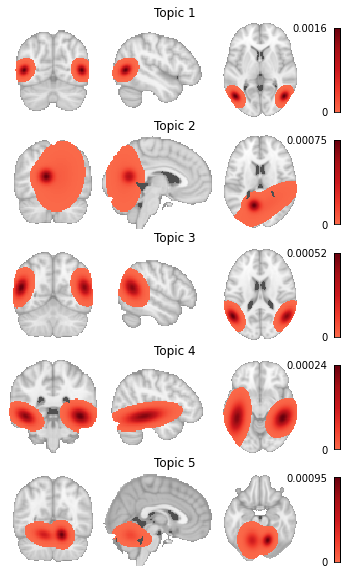

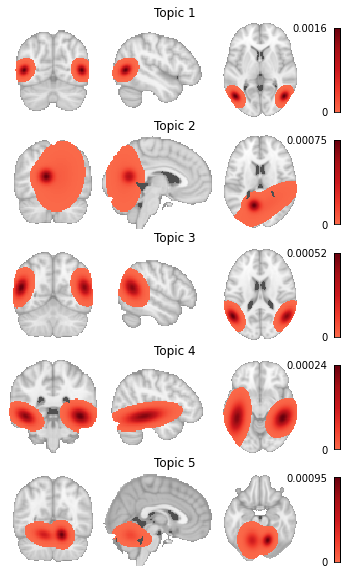

In [14]:
fig, axes = plt.subplots(nrows=5, figsize=(6, 10))

topic_img_4d = neurosynth_dset_first_500.masker.inverse_transform(gclda_model.p_voxel_g_topic_.T)
# Plot first five topics
for i_topic in range(5):
    topic_img = image.index_img(topic_img_4d, index=i_topic)
    display = plotting.plot_stat_map(
        topic_img,
        annotate=False,
        cmap="Reds",
        draw_cross=False,
        figure=fig,
        axes=axes[i_topic],
    )
    axes[i_topic].set_title(f"Topic {i_topic + 1}")

    colorbar = display._cbar
    colorbar_ticks = colorbar.get_ticks()
    if colorbar_ticks[0] < 0:
        new_ticks = [colorbar_ticks[0], 0, colorbar_ticks[-1]]
    else:
        new_ticks = [colorbar_ticks[0], colorbar_ticks[-1]]
    colorbar.set_ticks(new_ticks, update_ticks=True)

glue("figure_gclda_topics", fig, display=False)

```{glue:figure} figure_gclda_topics
:name: figure_gclda_topics
:align: center

Topic weight maps for the first five topics in the GCLDA model.
```

In [15]:
# Here we delete the recent variables for the sake of reducing memory usage
del gclda_model, temp_df, gclda_df, counts_df